# Evaluation of models on test data

In [2]:
from IPython import get_ipython
ipython = get_ipython()
if ipython:
    ipython.magic("reload_ext autoreload")
    ipython.magic("autoreload 2")

import util
import plotting
import evaluation
import preprocessing

import numpy as np
import pandas as pd
from skimage.color import label2rgb
from skimage import filters, measure, segmentation

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=20)
plt.rc('legend', fontsize=18)

from tqdm import tqdm
import tensorflow as tf

/tmp/ipykernel_113052/2893362789.py:4: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("reload_ext autoreload")
/tmp/ipykernel_113052/2893362789.py:5: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("autoreload 2")


In [3]:
#Define GPU device where the code will run on
gpu = tf.config.list_physical_devices('GPU')[0]
print(gpu)
tf.config.experimental.set_memory_growth(gpu, True)
gpu = tf.device('GPU:0/')

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


I0000 00:00:1735802877.262184  113052 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9471 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1


## Data and models directories

In [4]:
base_dir = '/mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/'
data_path = base_dir+'Data/' 
model_path = base_dir+'Models/' 

## No preprocessing, different batch sizes

### Only mito channel as input

In [35]:
#Inputs
input_data = util.load_h5(data_path, 'Mito')
print('Inputs'+':', input_data.shape)

#Outputs
output_data = util.load_h5(data_path, 'Proc')
print('Outputs:', output_data.shape)

labels = util.load_h5(data_path, 'labels')
print('Labels:', labels.shape)


Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/Mito.h5
Converting to array
Inputs: (37000, 128, 128)

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/Proc.h5
Converting to array
Outputs: (37000, 128, 128)

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/labels.h5
Converting to array
Labels: (37000, 128, 128)


In [ ]:
from pathlib import Path
folder_name = util.get_filename(model_path, 'ref_f8')
folder_name = [folder for folder in folder_name if folder.split('/')[-1][:3] == 'ref']
idx_sort = np.argsort([int(model_name.split('_b')[-1]) for model_name in folder_name])
folder_name = [folder_name[i] for i in idx_sort]
folder_name = [str(Path(folder).parts[-1]) for folder in folder_name]
nb_models = len(folder_name)

model = util.load_model(model_path, ['model']*nb_models, folder_name, as_type=dict)
history = util.load_pkl(model_path, ['history']*nb_models, folder_name, as_type=dict)
frames_test = util.load_pkl(model_path, ['frames_test']*nb_models, folder_name, as_type=dict)


Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/ref_f8_c9_b8/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/ref_f8_c9_b16/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/ref_f8_c9_b32/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/ref_f8_c9_b256/model.h5


Done.

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/ref_f8_c9_b8/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/ref_f8_c9_b16/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/ref_f8_c9_b32/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/ref_f8_c9_b256/history
Done.

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/ref_f8_c9_b8/frames_test

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/ref_f8_c9_b16/frames_test

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/ref_f8_c9_b32/frames_test

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/ref_f8_c9_b256/frames_test
Done

In [37]:
input_test, output_test, pred_output_test = {}, {}, {}
labels_test = {}

model_pbar = tqdm(model.keys())
for model_name in model_pbar:
  model_pbar.set_description("Processing %s" %model_name)
  input_test[model_name] = input_data[frames_test[model_name]]
  output_test[model_name] = output_data[frames_test[model_name]]
  labels_test[model_name] = labels[frames_test[model_name]]

  pred_output_test[model_name] = evaluation.predict(input_test[model_name], model[model_name])

del output_data, labels, input_data

Processing ref_f8_c9_b8:   0%|          | 0/4 [00:00<?, ?it/s]

232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step


Processing ref_f8_c9_b16:  25%|██▌       | 1/4 [00:07<00:22,  7.42s/it]

232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step


Processing ref_f8_c9_b32:  50%|█████     | 2/4 [00:14<00:14,  7.42s/it]

232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step


Processing ref_f8_c9_b256:  75%|███████▌  | 3/4 [00:21<00:07,  7.23s/it]

232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


Processing ref_f8_c9_b256: 100%|██████████| 4/4 [00:28<00:00,  7.17s/it]


#### Threshold optimization

In [39]:
pred_threshold = np.array([0.1, 0.2, 0.3, 0.5])
f1_score = {}
optimal_pred_threshold = {}
pred_labels_test = {}

for model_name in model:
  print("Processing %s" %model_name)
  f1_score[model_name] = evaluation.get_f1_curve(labels_test[model_name], pred_output_test[model_name], pred_threshold)
  
  optimal_pred_threshold[model_name] = evaluation.get_optimal_threshold(pred_threshold, f1_score[model_name])
  
  pred_labels_test[model_name] = evaluation.label(pred_output_test[model_name], threshold=optimal_pred_threshold[model_name])
  print('\n')
  
util.save_pkl(pred_threshold, model_path, 'ref_pred_threshold')
util.save_pkl(f1_score, model_path, 'ref_f1_score')
util.save_pkl(optimal_pred_threshold, model_path, 'ref_optimal_pred_threshold')

Processing ref_f8_c9_b8


  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:23<00:00,  5.85s/it]




Processing ref_f8_c9_b16


100%|██████████| 4/4 [00:23<00:00,  5.98s/it]




Processing ref_f8_c9_b32


100%|██████████| 4/4 [00:23<00:00,  5.80s/it]




Processing ref_f8_c9_b256


100%|██████████| 4/4 [00:23<00:00,  5.86s/it]





Saving /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/ref_pred_threshold
Done.

Saving /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/ref_f1_score
Done.

Saving /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/ref_optimal_pred_threshold
Done.


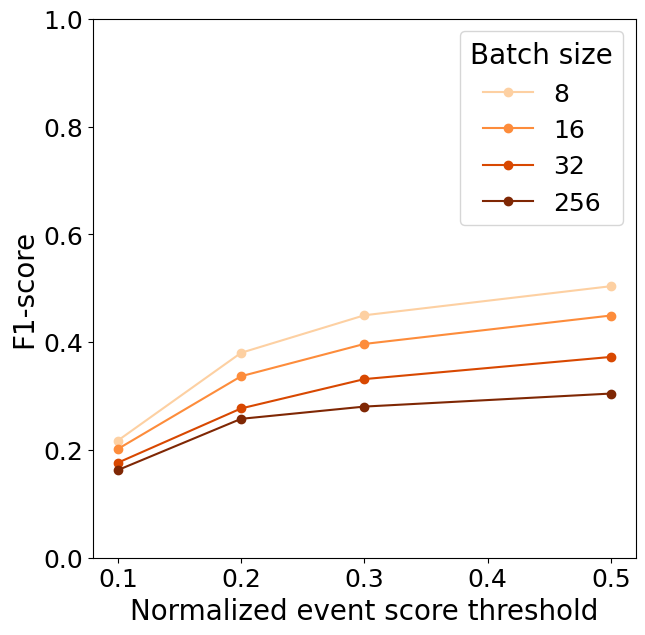

In [40]:
batch_size = [int(model_name.split('_b')[-1]) for model_name in folder_name]

num_models = len(batch_size)
cbar_ticks = np.arange(num_models)

norm_bounds = -1, num_models-1
norm = Normalize(*norm_bounds)
cmap = plt.cm.ScalarMappable(cmap='Oranges', norm=norm)
colors = cmap.get_cmap()(norm(cbar_ticks))

fig, ax = plt.subplots(figsize=(7, 7))
for model_name, b, c in zip(model, batch_size, colors):
  ax.plot(pred_threshold, f1_score[model_name], 'o-', color=c, label=b)

ax.set(xlabel='Normalized event score threshold', ylabel='F1-score', ylim=(0, 1))
ax.legend(title='Batch size', title_fontsize=20)
plt.show()

/mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Figures/ref_examples.pdf


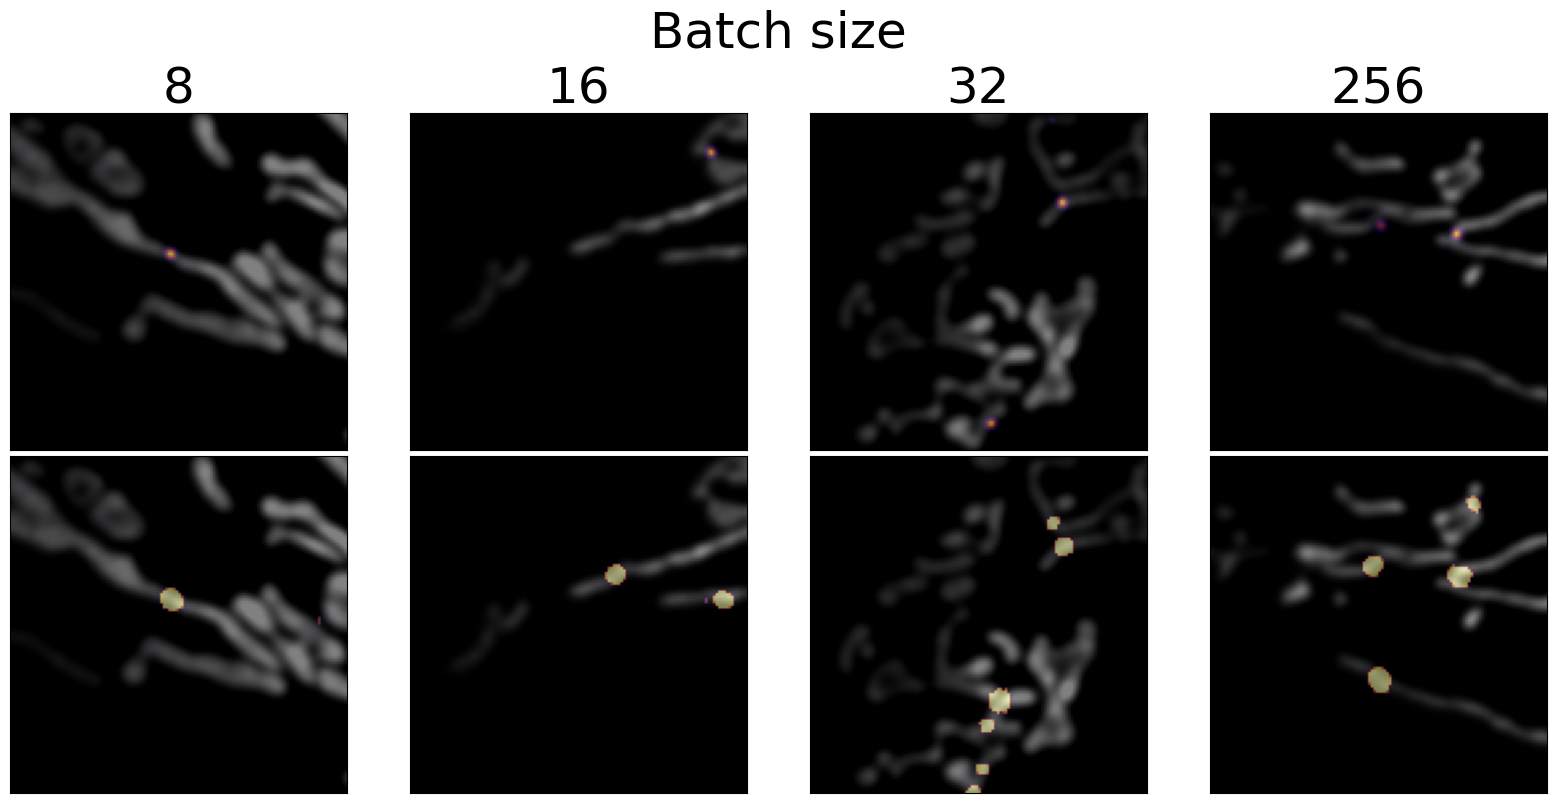

In [41]:
title = 'ref_examples'
filename = base_dir+'Figures/'+title+'.pdf'
print(filename)

title_size = 36

fig, axes = plt.subplots(2, nb_models, figsize=(4*nb_models, 8))
fig.suptitle('Batch size', size=title_size)
for model_name, b, i in zip(folder_name, [8, 16, 32, 256], range(nb_models)):
  frame = np.random.choice(np.where(np.any(np.any(output_test[model_name]>0, axis=-1), axis=-1))[0])
  mask = pred_output_test[model_name][frame]>optimal_pred_threshold[model_name]
  plotting.plot_merge(input_test[model_name][frame], output_test[model_name][frame], title='', ax=axes[0, i])
  plotting.plot_merge(input_test[model_name][frame], pred_output_test[model_name][frame]*mask, title='', ax=axes[1, i])
  axes[0, i].set_title(b, size=title_size)
  
fig.tight_layout(pad=0)
fig.subplots_adjust(wspace=0, hspace=0.02, top=0.85)
#plt.show()
fig.savefig(filename)

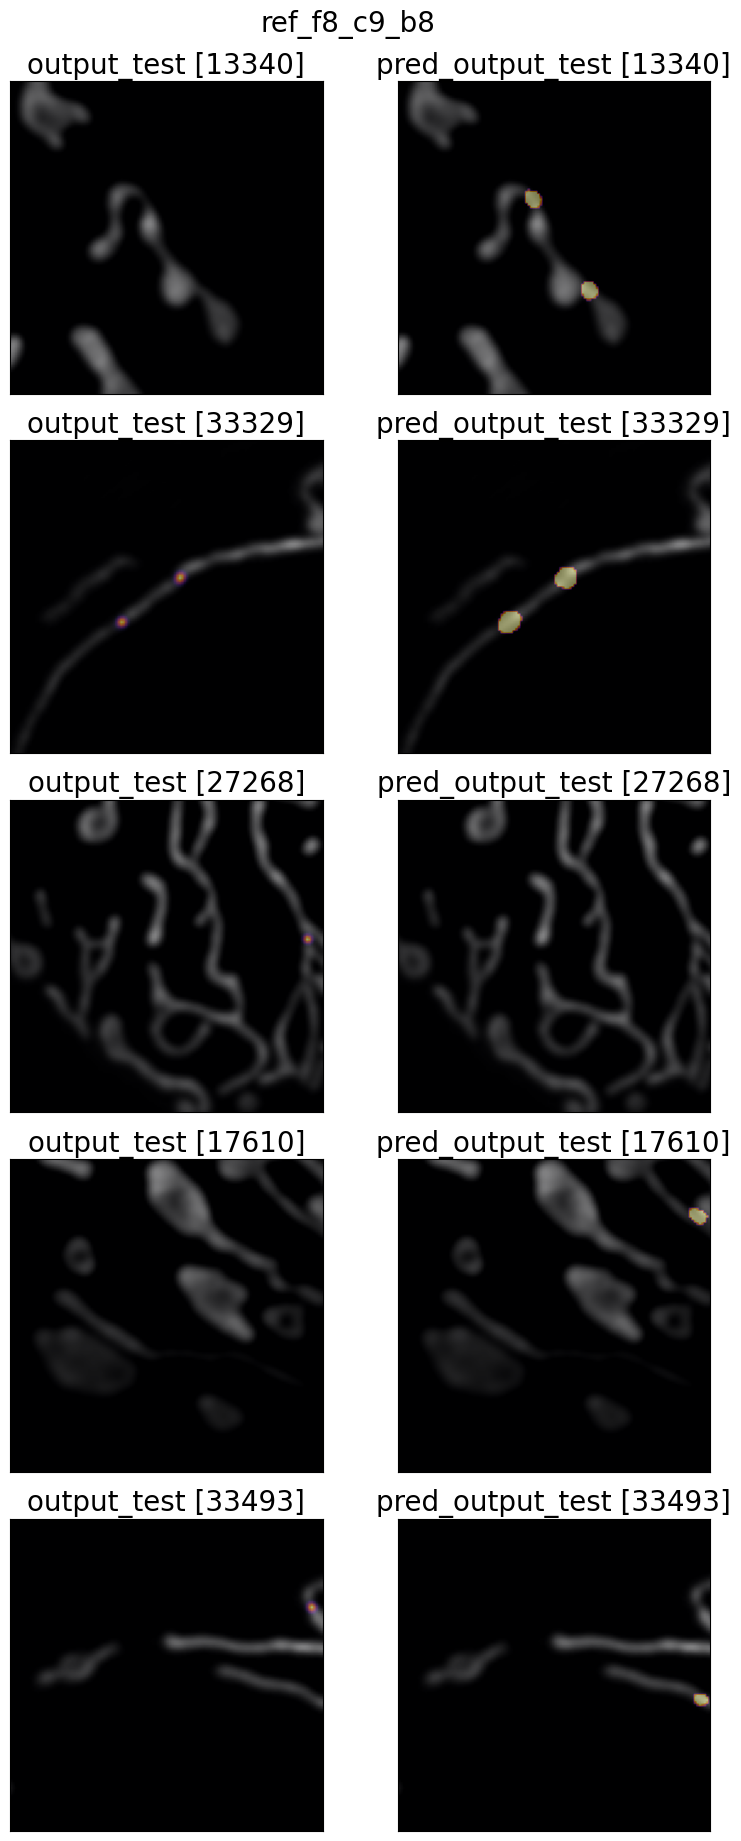

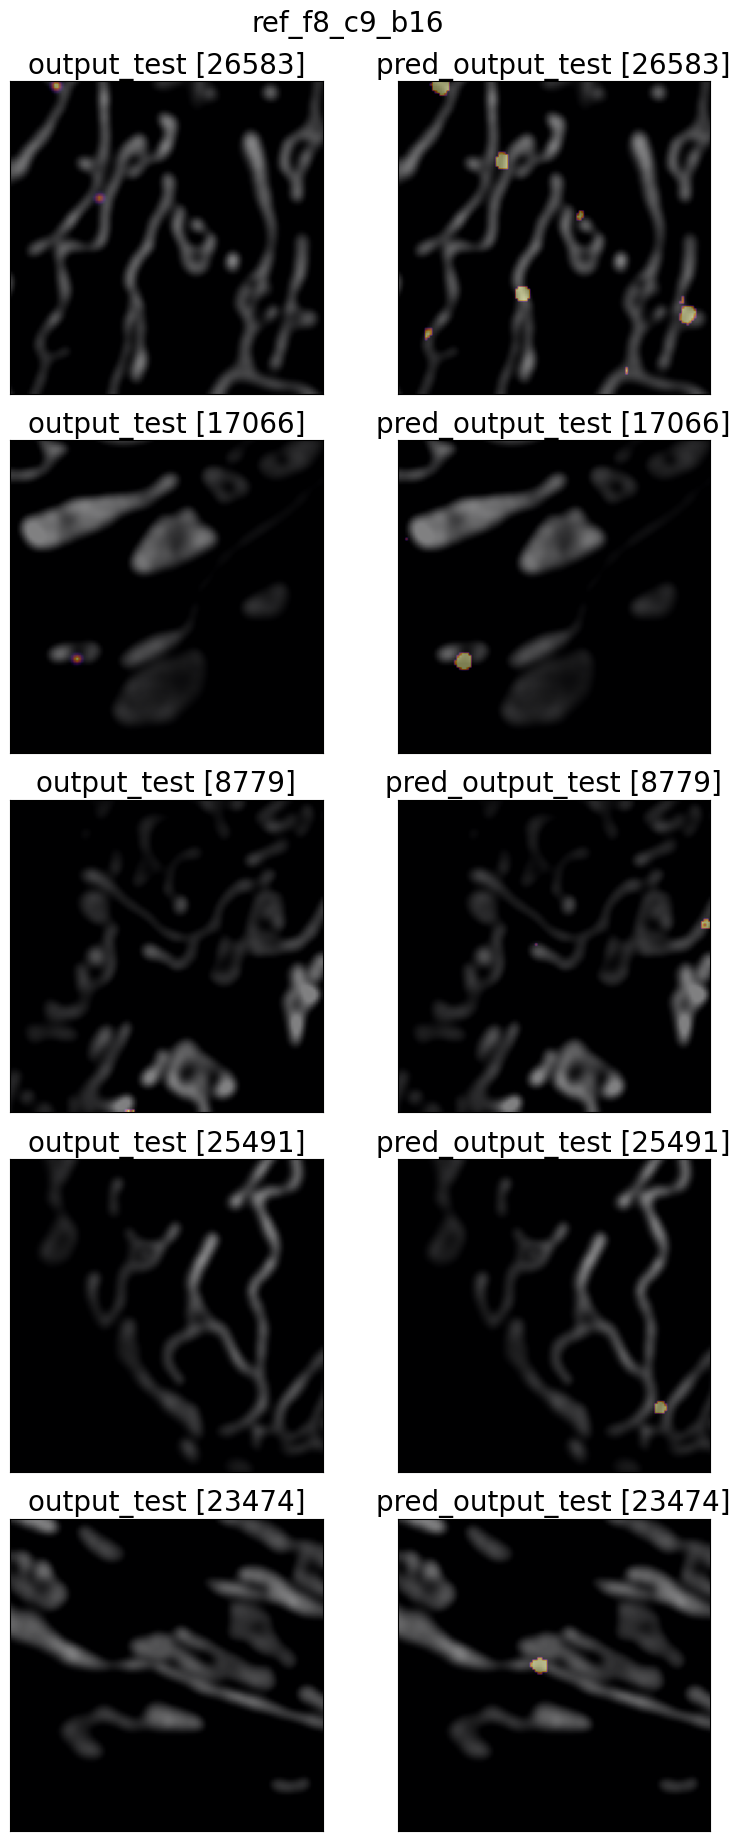

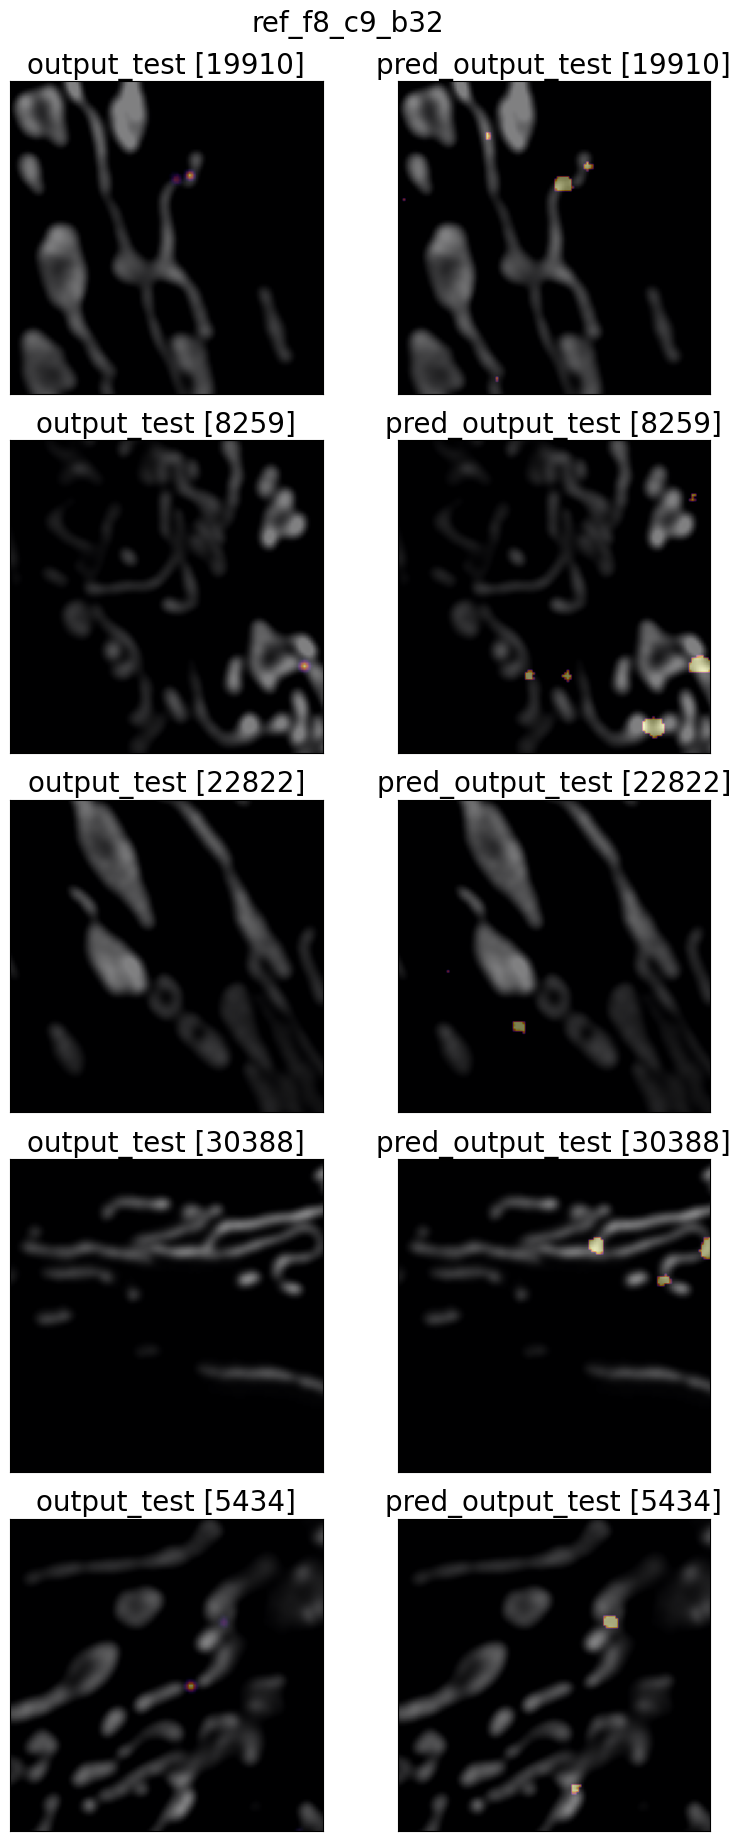

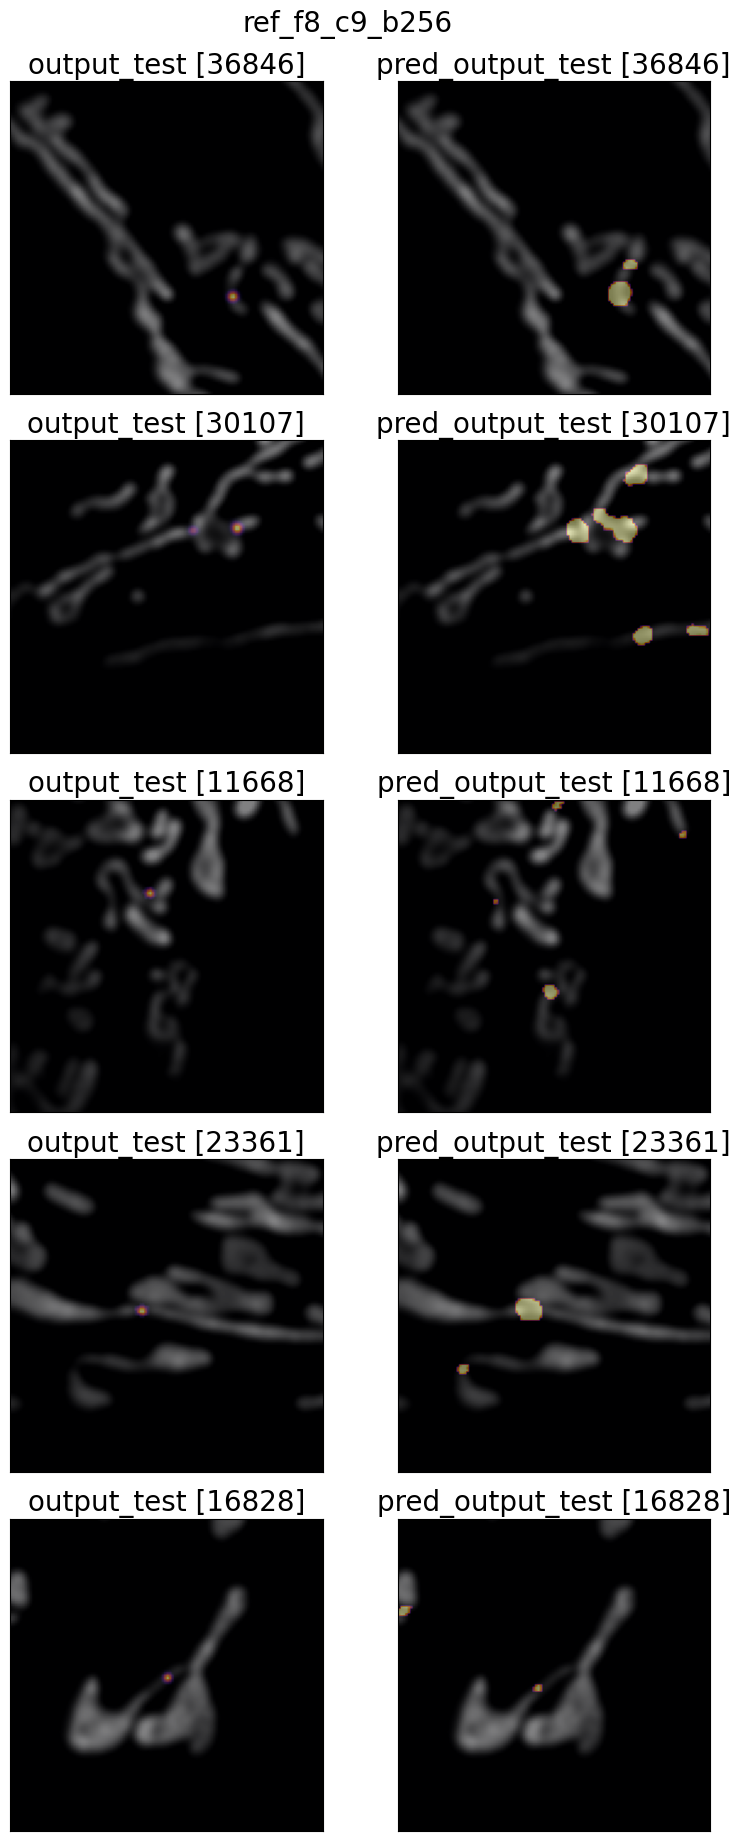

In [42]:
for model_name in folder_name:
  mask = pred_output_test[model_name]>optimal_pred_threshold[model_name]
  plotting.plot_outputs(input_test[model_name], output_test[model_name], 
                        pred_output_test[model_name]*mask, frames_test[model_name], 
                        nb_examples=5, title=model_name, cmap=['gray', 'inferno'])
  plt.show()
  print('\n')

#### Labels binary overlap

In [43]:
fissionStats = {}
for model_name in model:
  print('\nModel name:', model_name)
  fissionStats[model_name] = evaluation.fissionStatsStack(labels_test[model_name], pred_labels_test[model_name])
  
fissionStats = pd.DataFrame(fissionStats, index=['TP', 'FP', 'FN', 'TP_px', 'FP_px', 'FN_px']).T
fissionStats['precision'] = fissionStats['TP']/(fissionStats['TP']+fissionStats['FP'])
fissionStats['TPR'] = fissionStats['TP']/(fissionStats['TP']+fissionStats['FN'])
fissionStats['FDR'] = fissionStats['FP']/(fissionStats['TP']+fissionStats['FP'])

fissionStats['precision_px'] = fissionStats['TP_px']/(fissionStats['TP_px']+fissionStats['FP_px'])
fissionStats['TPR_px'] = fissionStats['TP_px']/(fissionStats['TP_px']+fissionStats['FN_px'])
fissionStats['FDR_px'] = fissionStats['FP_px']/(fissionStats['TP_px']+fissionStats['FP_px'])

fissionStats = fissionStats.T


Model name: ref_f8_c9_b8

Model name: ref_f8_c9_b16

Model name: ref_f8_c9_b32

Model name: ref_f8_c9_b256


/mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Figures/ref_fissionStats.png


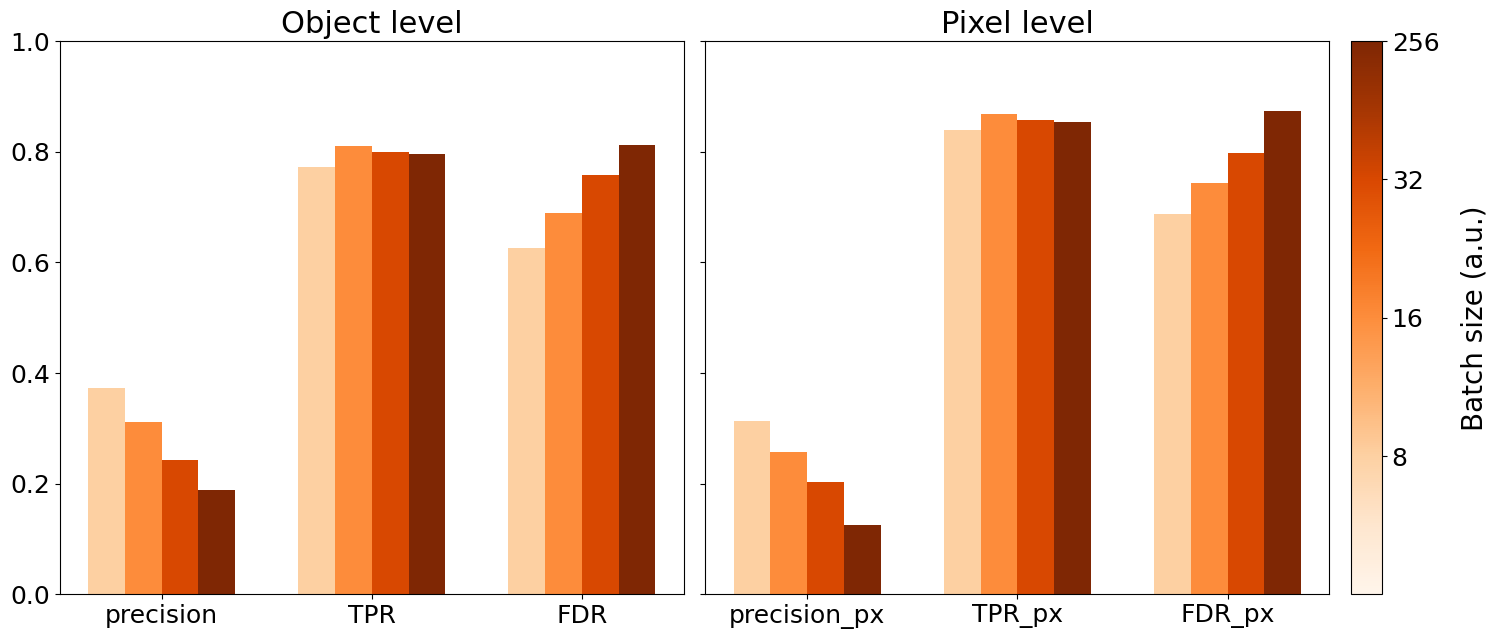

In [44]:
title = 'ref_fissionStats'
filename = base_dir+'Figures/'+title+'.png'
print(filename)

fig = plt.figure(figsize=(7*2, 7))
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 0.05])

axes = []
axes += [fig.add_subplot(gs[0])]
axes += [fig.add_subplot(gs[1])]
cax = fig.add_subplot(gs[2])


plotting.plot_metrics_comparison(fissionStats.loc[['precision', 'TPR', 'FDR']], xscale=2, color=colors, ax=axes[0], ylim=[0, 1], legend=False)  
plotting.plot_metrics_comparison(fissionStats.loc[['precision_px', 'TPR_px', 'FDR_px']], xscale=2, color=colors, ax=axes[1], ylim=[0, 1], legend=False)
axes[1].set_yticklabels([])

for ax, title in zip(axes, ['Object level', 'Pixel level']):
  ax.set_title(title, size=22)
  ax.tick_params(axis='x')
  ax.tick_params(axis='y')

cbar = fig.colorbar(cmap, cax=cax, ticks=cbar_ticks)
cbar.set_ticklabels(batch_size)
cbar.set_label('Batch size (a.u.)', labelpad=15)


plt.tight_layout(pad=0)
fig.subplots_adjust(wspace=0.05, top=0.84, right=0.98)

#plt.show()
fig.savefig(filename)

#### Detection match

In [45]:
det_match = [evaluation.detection_match(output_test[model_name], pred_output_test[model_name]) for model_name in folder_name]

/mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Figures/ref_det_match_new.png


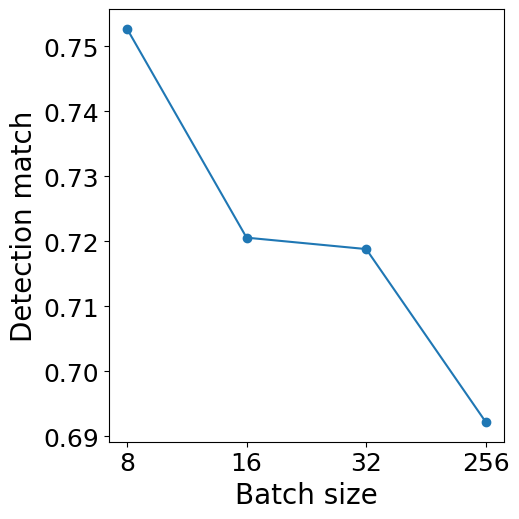

In [46]:
facecolor = (0.13, 0.13, 0.13, 1)
title = 'ref_det_match_new'
filename = base_dir+'Figures/'+title+'.png'
print(filename)

fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(det_match, 'o-')
ax.set_xticks(range(len(det_match)))
ax.set_xticklabels([8, 16, 32, 256])
ax.set_xlabel('Batch size')
ax.set_ylabel('Detection match')

ax.tick_params(axis='x')
ax.tick_params(axis='y')

plt.tight_layout(pad=0)
#plt.show()
fig.savefig(filename)

### Mito + Drp1 channels as inputs

In [47]:
#Inputs
input_data = util.load_h5(data_path, 'Mito')
input_data = np.stack((input_data, util.load_h5(data_path, 'Drp1')), axis=-1)
print('Inputs'+':', input_data.shape)

#Outputs
output_data = util.load_h5(data_path, 'Proc')
print('Outputs:', output_data.shape)

labels = util.load_h5(data_path, 'labels')
print('Labels:', labels.shape)


Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/Mito.h5
Converting to array

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/Drp1.h5
Converting to array
Inputs: (37000, 128, 128, 2)

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/Proc.h5
Converting to array
Outputs: (37000, 128, 128)

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/labels.h5
Converting to array
Labels: (37000, 128, 128)


In [51]:
folder_name

['/mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_ref_f8_c9_b8',
 '/mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_ref_f8_c9_b16',
 '/mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_ref_f8_c9_b32',
 '/mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_ref_f8_c9_b256']

In [53]:
folder_name = util.get_filename(model_path, 'multich_ref_f8')
idx_sort = np.argsort([int(model_name.split('_b')[-1]) for model_name in folder_name])

folder_name = [folder_name[i] for i in idx_sort]
folder_name = [str(Path(folder).parts[-1]) for folder in folder_name]
# folder_name = [folder for folder in folder_name if folder.split('/')[-1][:3] == 'mul']
nb_models = len(folder_name)

model = util.load_model(model_path, ['model']*nb_models, folder_name, as_type=dict)
history = util.load_pkl(model_path, ['history']*nb_models, folder_name, as_type=dict)
frames_test = util.load_pkl(model_path, ['frames_test']*nb_models, folder_name, as_type=dict)


Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_ref_f8_c9_b8/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_ref_f8_c9_b16/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_ref_f8_c9_b32/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_ref_f8_c9_b256/model.h5


Done.

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_ref_f8_c9_b8/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_ref_f8_c9_b16/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_ref_f8_c9_b32/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_ref_f8_c9_b256/history
Done.

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_ref_f8_c9_b8/frames_test

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_ref_f8_c9_b16/frames_test

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_ref_f8_c9_b32/frames_test

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_f

In [54]:
input_test, output_test, pred_output_test = {}, {}, {}
labels_test = {}

model_pbar = tqdm(model.keys())
for model_name in model_pbar:
  model_pbar.set_description("Processing %s" %model_name)
  input_test[model_name] = input_data[frames_test[model_name]]
  output_test[model_name] = output_data[frames_test[model_name]]
  labels_test[model_name] = labels[frames_test[model_name]]

  pred_output_test[model_name] = evaluation.predict(input_test[model_name], model[model_name])

del output_data, labels, input_data

Processing multich_ref_f8_c9_b8:   0%|          | 0/4 [00:00<?, ?it/s]

232/232 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step


Processing multich_ref_f8_c9_b16:  25%|██▌       | 1/4 [00:07<00:23,  7.96s/it]

232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step


Processing multich_ref_f8_c9_b32:  50%|█████     | 2/4 [00:15<00:15,  7.69s/it]

232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step


Processing multich_ref_f8_c9_b256:  75%|███████▌  | 3/4 [00:23<00:07,  7.69s/it]

232/232 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step


Processing multich_ref_f8_c9_b256: 100%|██████████| 4/4 [00:31<00:00,  7.90s/it]


#### Threshold optimization

In [55]:
pred_threshold = np.array([0.1, 0.2, 0.3, 0.5])
f1_score = {}
optimal_pred_threshold = {}
pred_labels_test = {}

for model_name in model:
  print("Processing %s" %model_name)
  f1_score[model_name] = evaluation.get_f1_curve(labels_test[model_name], pred_output_test[model_name], pred_threshold)
  
  optimal_pred_threshold[model_name] = evaluation.get_optimal_threshold(pred_threshold, f1_score[model_name])
  
  pred_labels_test[model_name] = evaluation.label(pred_output_test[model_name], threshold=optimal_pred_threshold[model_name])
  print('\n')
  
util.save_pkl(f1_score, model_path, 'multich_ref_f1_score')
util.save_pkl(optimal_pred_threshold, model_path, 'multich_ref_optimal_pred_threshold')

Processing multich_ref_f8_c9_b8


100%|██████████| 4/4 [00:24<00:00,  6.16s/it]




Processing multich_ref_f8_c9_b16


100%|██████████| 4/4 [00:24<00:00,  6.11s/it]




Processing multich_ref_f8_c9_b32


100%|██████████| 4/4 [00:24<00:00,  6.06s/it]




Processing multich_ref_f8_c9_b256


100%|██████████| 4/4 [00:23<00:00,  5.89s/it]





Saving /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_ref_f1_score
Done.

Saving /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_ref_optimal_pred_threshold
Done.


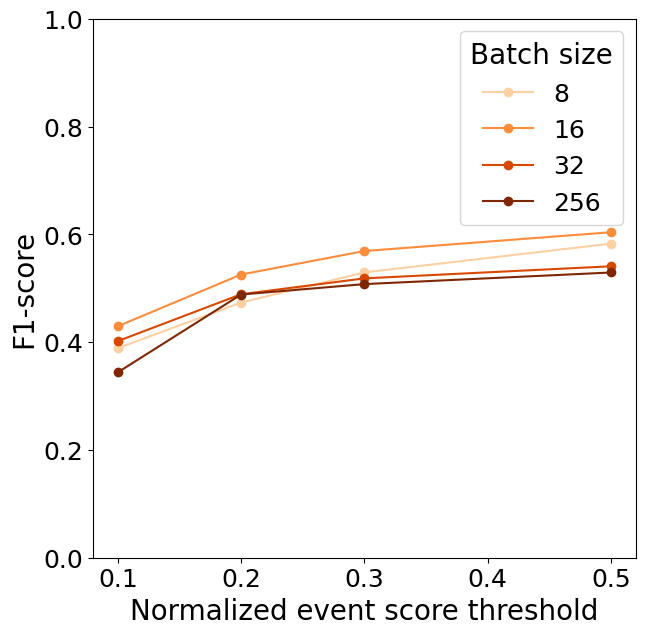

In [56]:
batch_size = [int(model_name.split('_b')[-1]) for model_name in folder_name]

num_models = len(batch_size)
cbar_ticks = np.arange(num_models)

norm_bounds = -1, num_models-1
norm = Normalize(*norm_bounds)
cmap = plt.cm.ScalarMappable(cmap='Oranges', norm=norm)
colors = cmap.get_cmap()(norm(cbar_ticks))

fig, ax = plt.subplots(figsize=(7, 7))
for model_name, b, c in zip(model, batch_size, colors):
  ax.plot(pred_threshold, f1_score[model_name], 'o-', color=c, label=b)

ax.set(xlabel='Normalized event score threshold', ylabel='F1-score', ylim=(0, 1))
ax.legend(title='Batch size', title_fontsize=20)
plt.show()

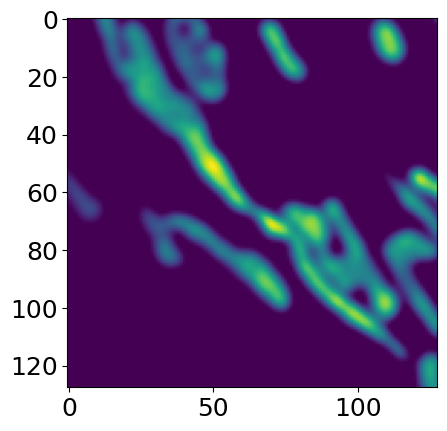

In [57]:
plt.imshow(input_test[model_name][frame][:, :, 0])

/mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Figures/multich_ref_examples.pdf


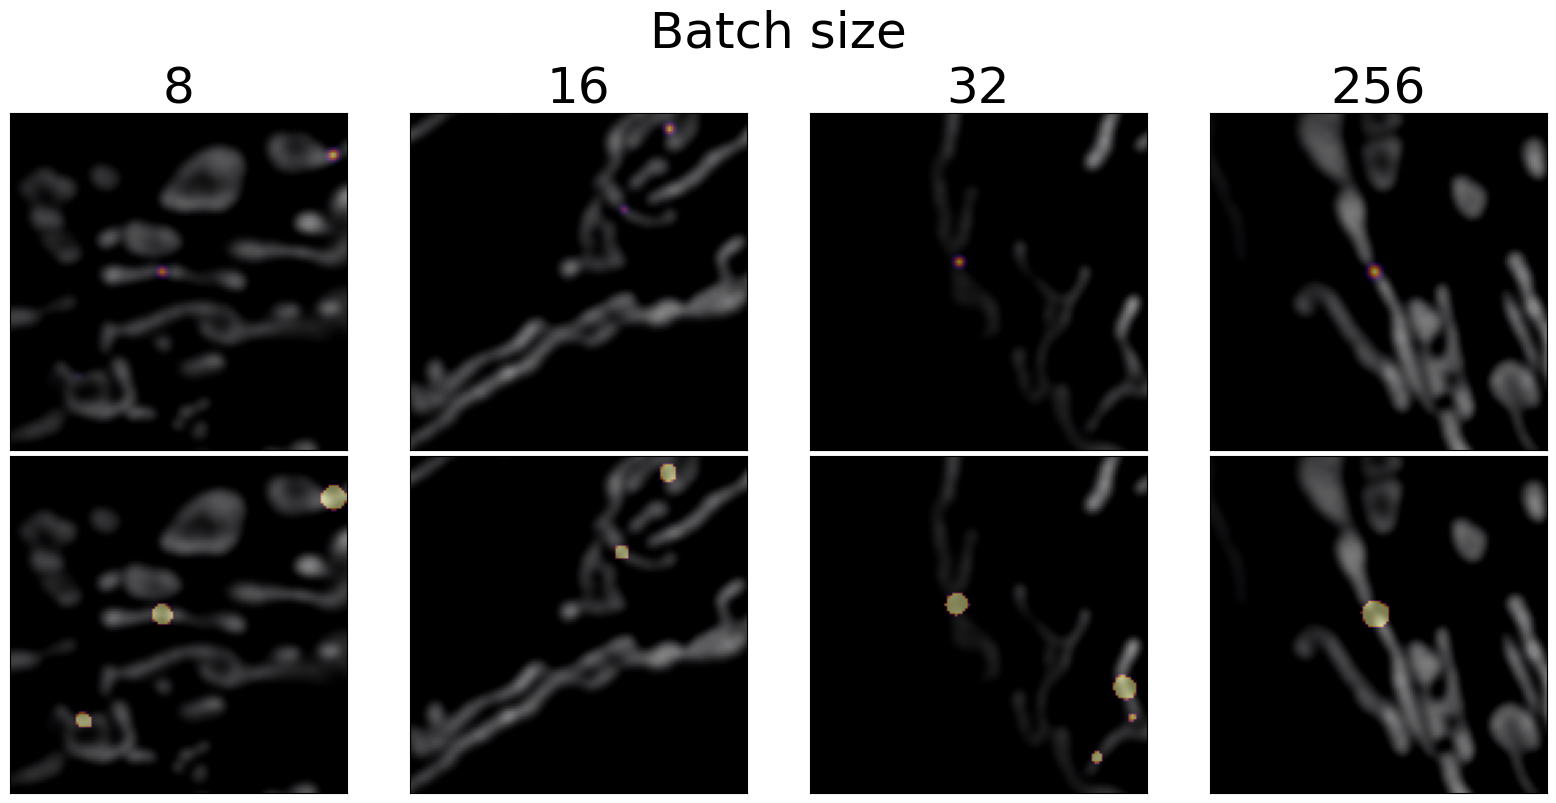

In [58]:
title = 'multich_ref_examples'
filename = base_dir+'Figures/'+title+'.pdf'
print(filename)

title_size = 36

fig, axes = plt.subplots(2, nb_models, figsize=(4*nb_models, 8))
fig.suptitle('Batch size', size=title_size)
for model_name, b, i in zip(folder_name, [8, 16, 32, 256], range(nb_models)):
  frame = np.random.choice(np.where(np.any(np.any(output_test[model_name]>0, axis=-1), axis=-1))[0])
  mask = pred_output_test[model_name][frame]>optimal_pred_threshold[model_name]
  plotting.plot_merge(input_test[model_name][frame][:, :, 0], output_test[model_name][frame], title='', ax=axes[0, i])
  plotting.plot_merge(input_test[model_name][frame][:, :, 0], pred_output_test[model_name][frame]*mask, title='', ax=axes[1, i])
  axes[0, i].set_title(b, size=title_size)
  
fig.tight_layout(pad=0)
fig.subplots_adjust(wspace=0, hspace=0.02, top=0.85)
#plt.show()
fig.savefig(filename)

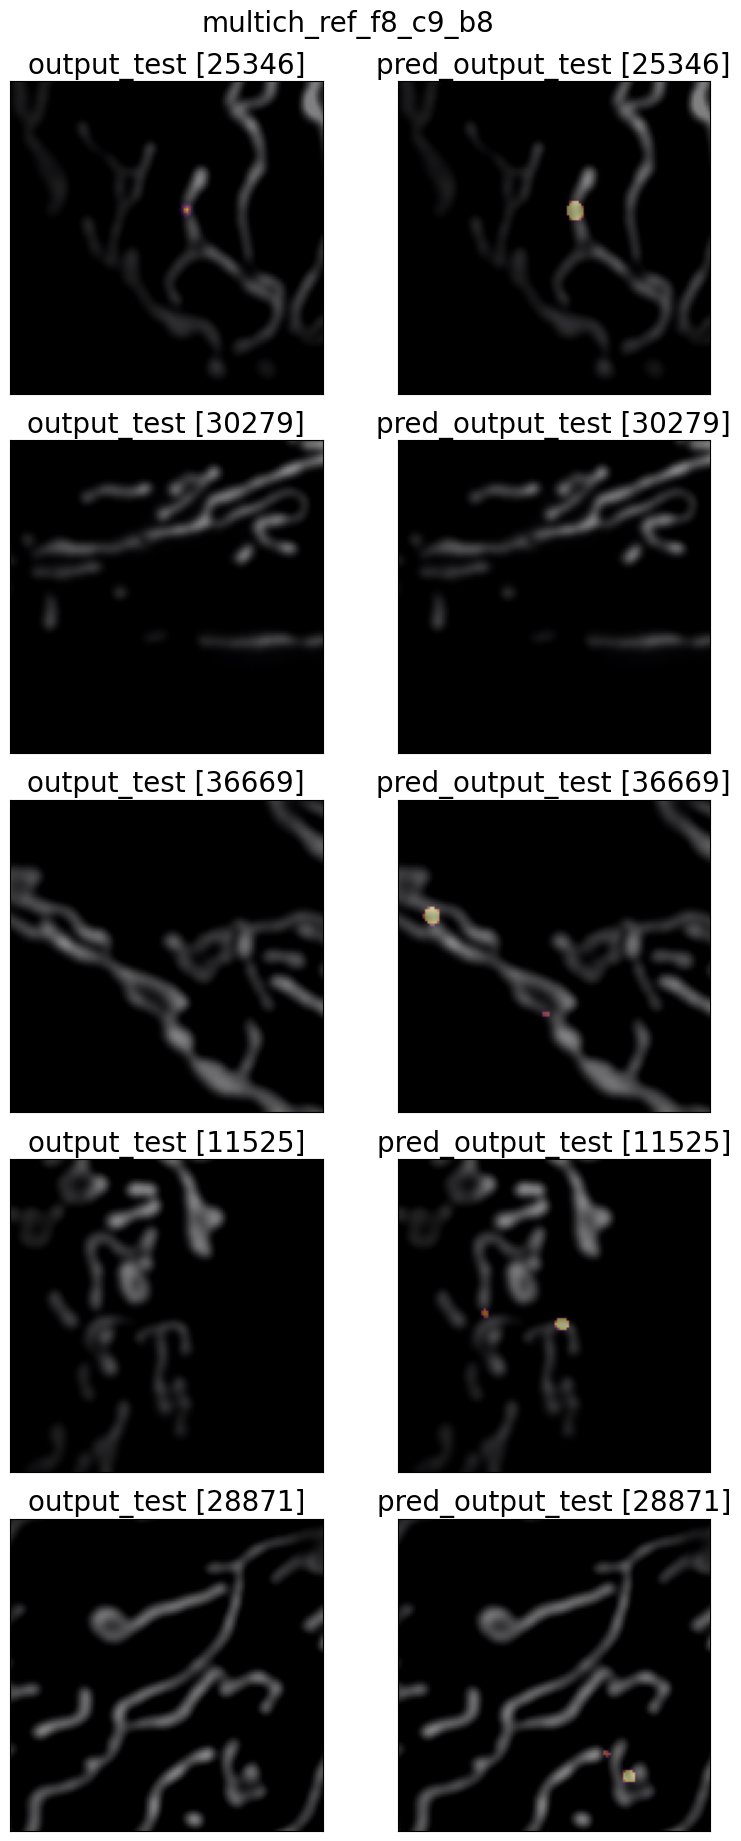

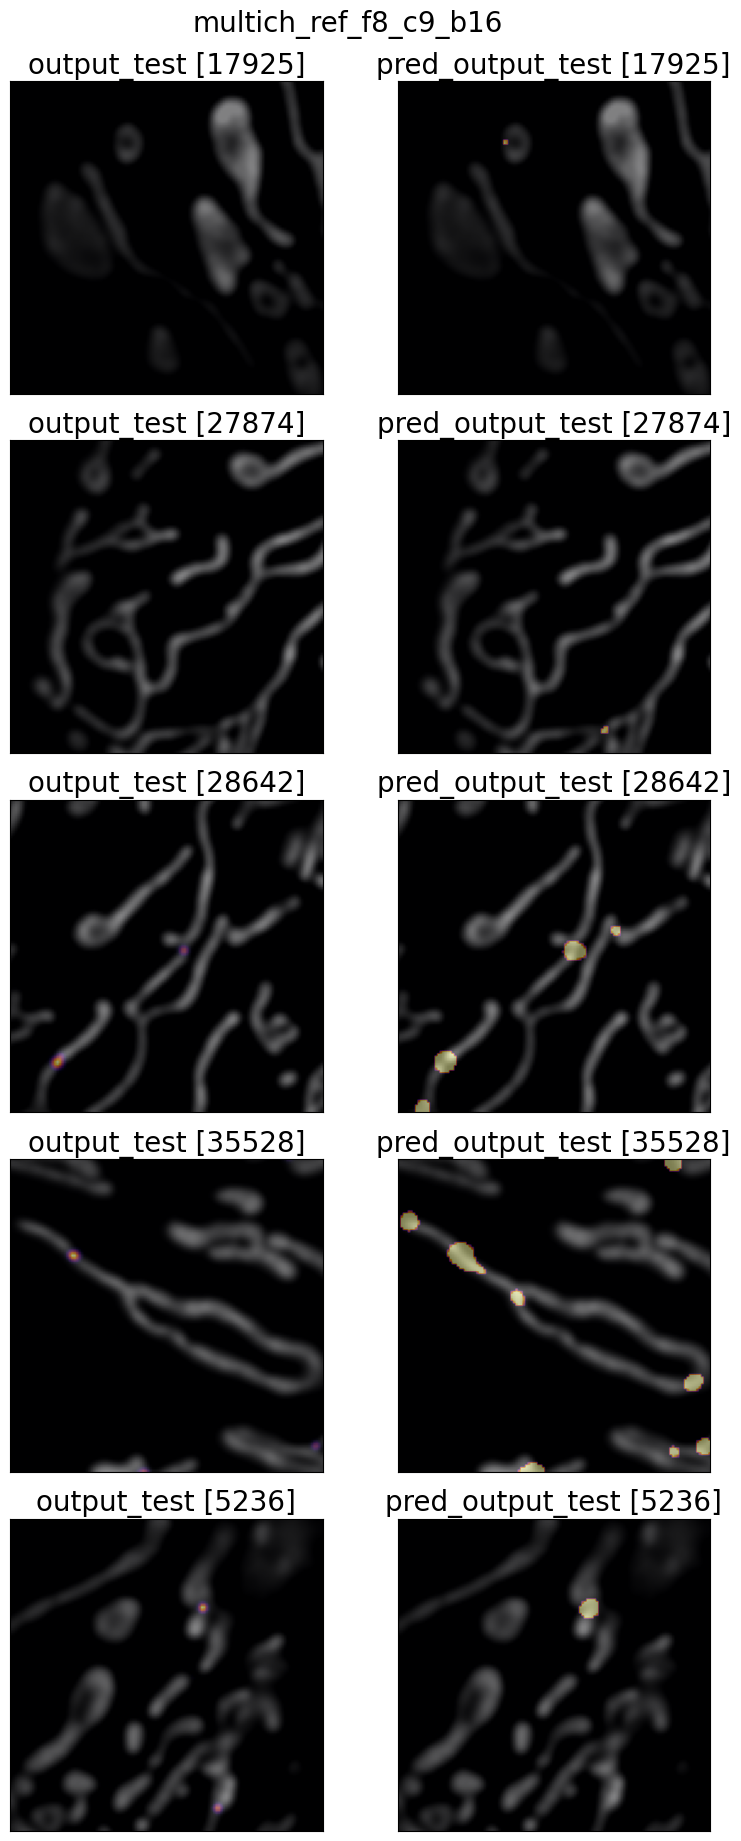

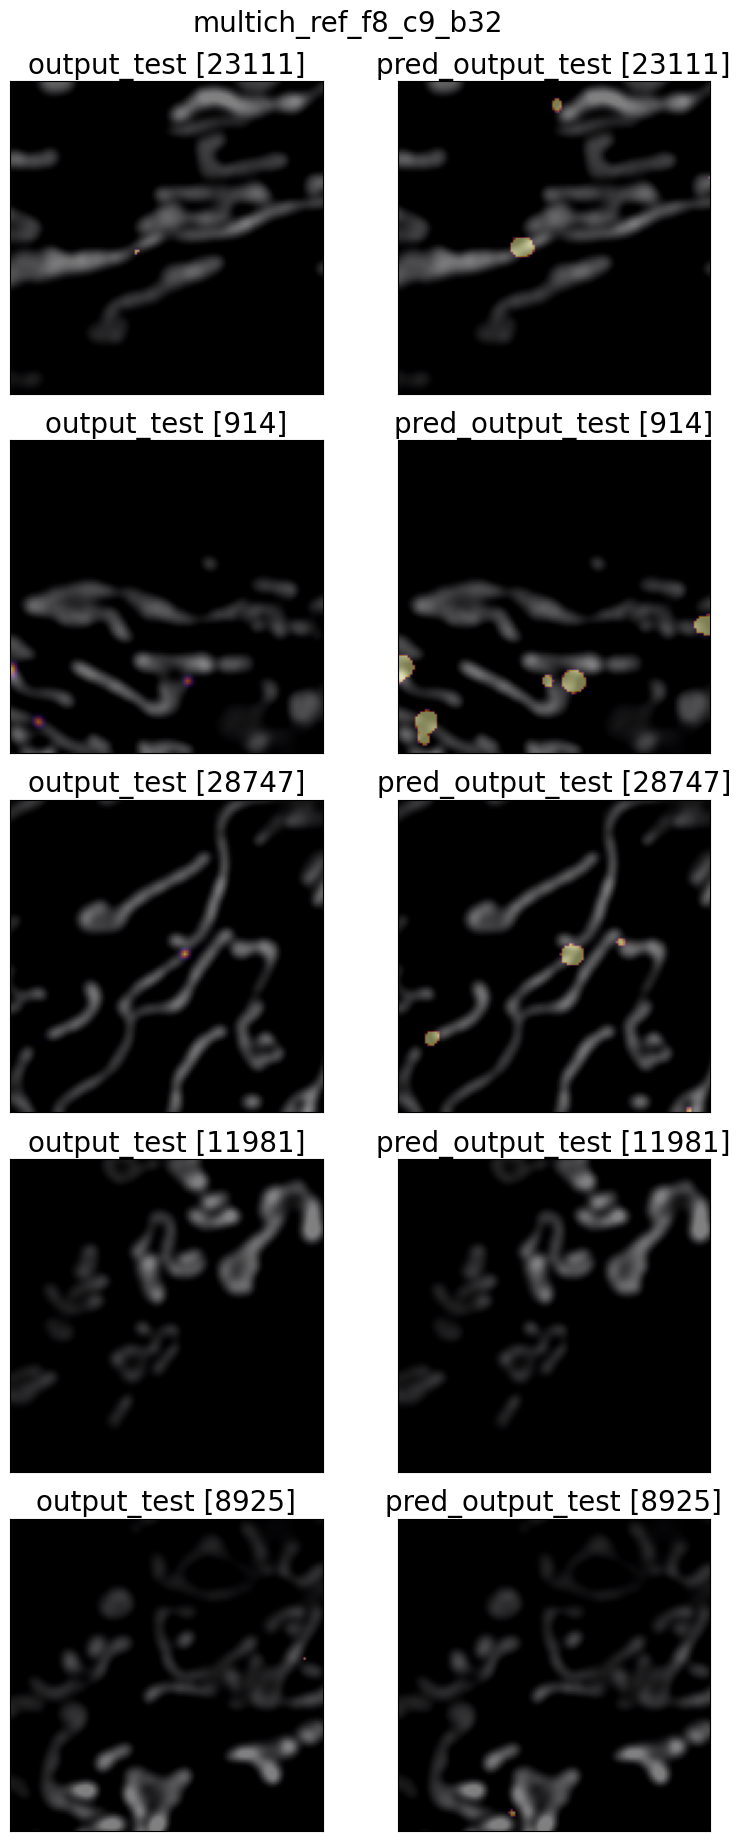

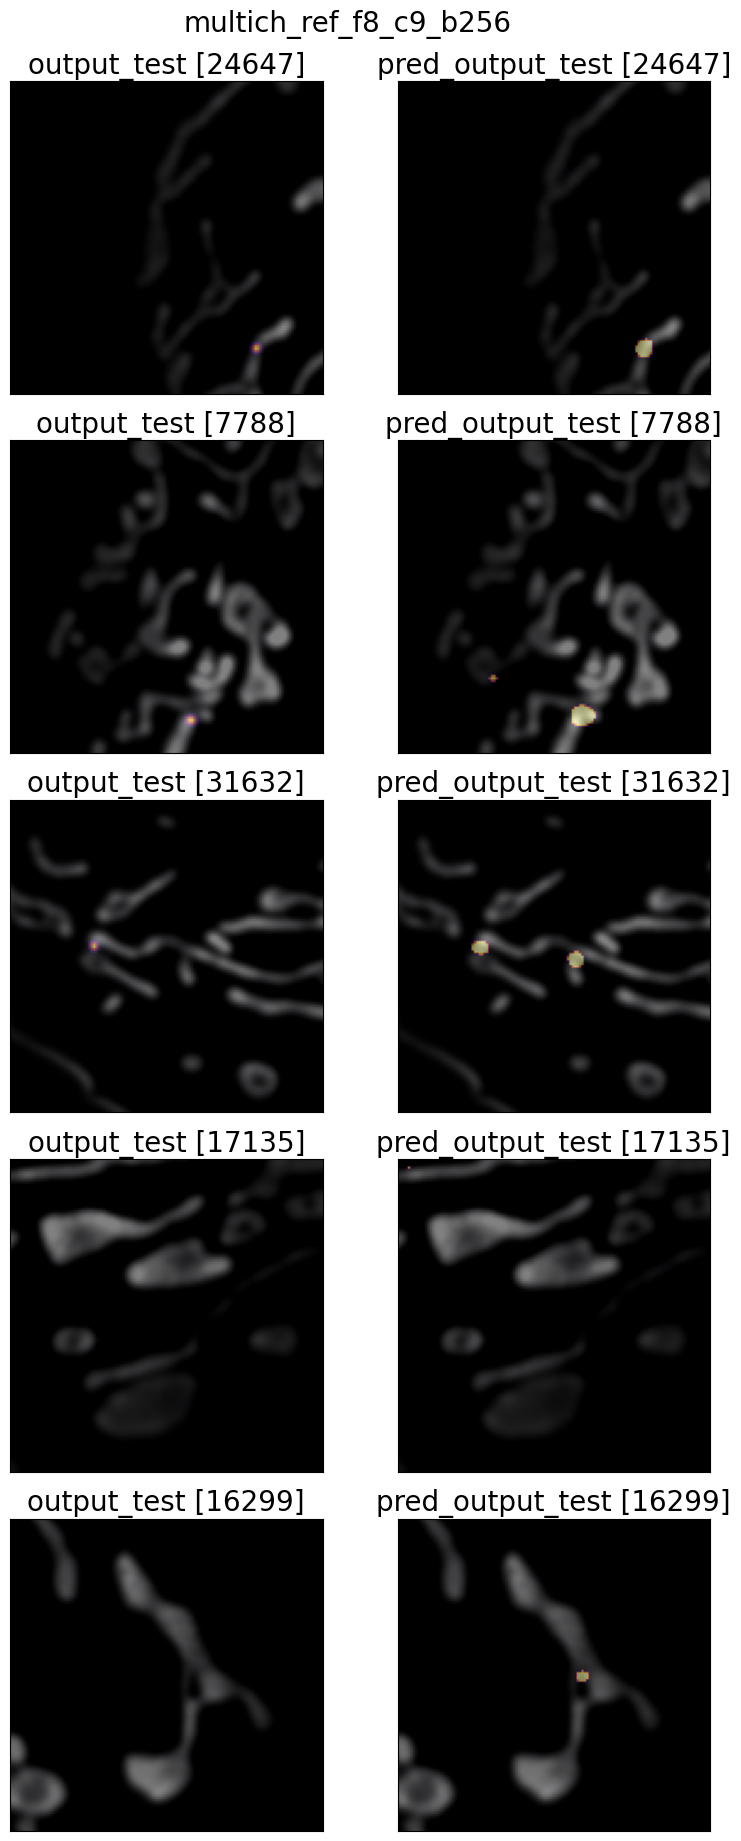

In [59]:
for model_name in folder_name:
  mask = pred_output_test[model_name]>optimal_pred_threshold[model_name]
  plotting.plot_outputs(input_test[model_name][:, :, :, 0], output_test[model_name], 
                        pred_output_test[model_name]*mask, frames_test[model_name], 
                        nb_examples=5, title=model_name, cmap=['gray', 'inferno'])
  plt.show()
  print('\n')

#### Labels binary overlap

In [60]:
fissionStats = {}
for model_name in model:
  print('\nModel name:', model_name)
  fissionStats[model_name] = evaluation.fissionStatsStack(labels_test[model_name], pred_labels_test[model_name])
  
fissionStats = pd.DataFrame(fissionStats, index=['TP', 'FP', 'FN', 'TP_px', 'FP_px', 'FN_px']).T
fissionStats['precision'] = fissionStats['TP']/(fissionStats['TP']+fissionStats['FP'])
fissionStats['TPR'] = fissionStats['TP']/(fissionStats['TP']+fissionStats['FN'])
fissionStats['FDR'] = fissionStats['FP']/(fissionStats['TP']+fissionStats['FP'])

fissionStats['precision_px'] = fissionStats['TP_px']/(fissionStats['TP_px']+fissionStats['FP_px'])
fissionStats['TPR_px'] = fissionStats['TP_px']/(fissionStats['TP_px']+fissionStats['FN_px'])
fissionStats['FDR_px'] = fissionStats['FP_px']/(fissionStats['TP_px']+fissionStats['FP_px'])

fissionStats = fissionStats.T


Model name: multich_ref_f8_c9_b8

Model name: multich_ref_f8_c9_b16

Model name: multich_ref_f8_c9_b32

Model name: multich_ref_f8_c9_b256


/mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Figures/multich_ref_fissionStats.png


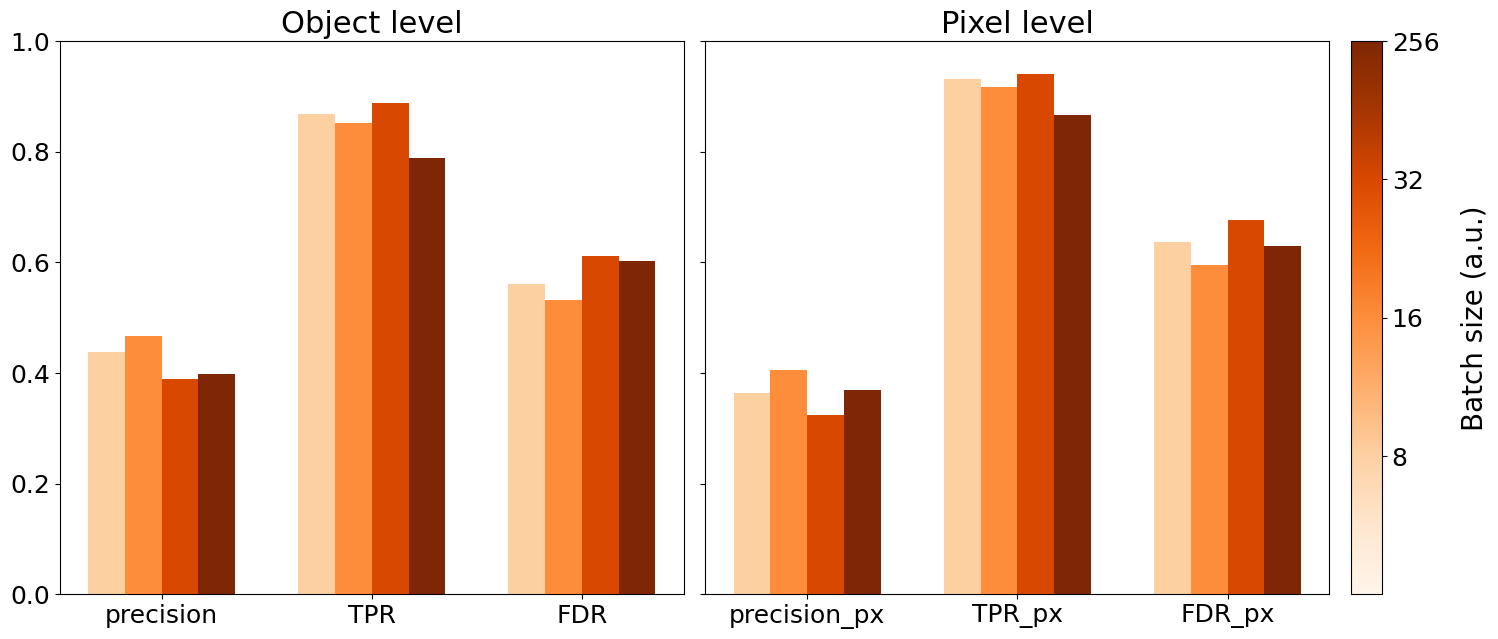

In [61]:
title = 'multich_ref_fissionStats'
filename = base_dir+'Figures/'+title+'.png'
print(filename)

fig = plt.figure(figsize=(7*2, 7))
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 0.05])

axes = []
axes += [fig.add_subplot(gs[0])]
axes += [fig.add_subplot(gs[1])]
cax = fig.add_subplot(gs[2])


plotting.plot_metrics_comparison(fissionStats.loc[['precision', 'TPR', 'FDR']], xscale=2, color=colors, ax=axes[0], ylim=[0, 1], legend=False)  
plotting.plot_metrics_comparison(fissionStats.loc[['precision_px', 'TPR_px', 'FDR_px']], xscale=2, color=colors, ax=axes[1], ylim=[0, 1], legend=False)
axes[1].set_yticklabels([])

for ax, title in zip(axes, ['Object level', 'Pixel level']):
  ax.set_title(title, size=22)
  ax.tick_params(axis='x')
  ax.tick_params(axis='y')

cbar = fig.colorbar(cmap, cax=cax, ticks=cbar_ticks)
cbar.set_ticklabels(batch_size)
cbar.set_label('Batch size (a.u.)', labelpad=15)


plt.tight_layout(pad=0)
fig.subplots_adjust(wspace=0.05, top=0.84, right=0.98)

#plt.show()
fig.savefig(filename)

#### Detection match

In [62]:
det_match = [evaluation.detection_match(output_test[model_name], pred_output_test[model_name]) for model_name in folder_name]

/mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Figures/multich_ref_det_match.png


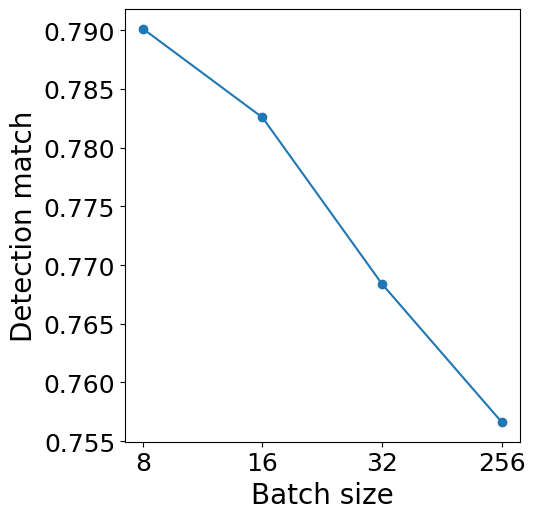

In [63]:
facecolor = (0.13, 0.13, 0.13, 1)
title = 'multich_ref_det_match'
filename = base_dir+'Figures/'+title+'.png'
print(filename)

fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(det_match, 'o-')
ax.set_xticks(range(len(det_match)))
ax.set_xticklabels([8, 16, 32, 256])
ax.set_xlabel('Batch size')
ax.set_ylabel('Detection match')

ax.tick_params(axis='x')
ax.tick_params(axis='y')

plt.tight_layout(pad=0)
#plt.show()
fig.savefig(filename)

## Mito & WatProc, different spot sizes

### Only mito channel as input

In [64]:
#Inputs
input_data = util.load_h5(data_path, 'Mito')
print('Inputs'+':', input_data.shape)

dilation_sigma = util.load_pkl(data_path, 'max_optimal_sigma')
dilation_threshold = util.load_pkl(data_path, 'max_intensity_threshold')
num_sigmas = dilation_sigma.shape[0]


Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/Mito.h5
Converting to array
Inputs: (37000, 128, 128)

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/max_optimal_sigma

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/max_intensity_threshold


In [69]:
#Outputs
folder_name = util.get_filename(model_path, 'wp_f8')
folder_name = [model_name for model_name in folder_name if np.all([tag not in model_name for tag in ['aug', 'temp', 'multich']])]
folder_name = [str(Path(folder).parts[-1]) for folder in folder_name]
num_models = len(folder_name)

model = util.load_model(model_path, ['model']*num_models, folder_name, as_type=dict)
history = util.load_pkl(model_path, ['history']*num_models, folder_name, as_type=dict)
frames_test = util.load_pkl(model_path, ['frames_test']*num_models, folder_name, as_type=dict)


Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/wp_f8_c9_b16_s2.2_t68/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/wp_f8_c9_b16_s1.9_t1/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/wp_f8_c9_b16_s2.2_t98/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/wp_f8_c9_b16_s2.1_t33/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/wp_f8_c9_b16_s2.1_t48/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/wp_f8_c9_b16_s1.9_t6/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/wp_f8_c9_b16_s2.0_t21/model.h5


Done.

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/wp_f8_c9_b16_s2.2_t68/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/wp_f8_c9_b16_s1.9_t1/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/wp_f8_c9_b16_s2.2_t98/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/wp_f8_c9_b16_s2.1_t33/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/wp_f8_c9_b16_s2.1_t48/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/wp_f8_c9_b16_s1.9_t6/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/wp_f8_c9_b16_s2.0_t21/history
Done.

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit

In [70]:
input_test, output_test, pred_output_test = {}, {}, {}
labels_test = {}

for model_name, s, t in zip(folder_name, dilation_sigma, dilation_threshold):
  print('\nModel: %s'%model_name)
  
  #Inputs
  input_test[model_name] = input_data[frames_test[model_name]]
  
  metadata = 's%.1f_t%.i'%(s, t)
  #Outputs
  output_data = util.load_h5(data_path, 'WatProc_'+metadata)
  print('Outputs:', output_data.shape)
  output_test[model_name] = output_data[frames_test[model_name]]
  del output_data
  
  #Labels
  labels = util.load_h5(data_path, 'proc_labels_'+metadata)
  print('Labels:', labels.shape)
  labels_test[model_name] = labels[frames_test[model_name]]
  del labels
  
  pred_output_test[model_name] = evaluation.predict(input_test[model_name], model[model_name])

del input_data


Model: wp_f8_c9_b16_s2.2_t68

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/WatProc_s1.9_t1.h5
Converting to array
Outputs: (37000, 128, 128)

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/proc_labels_s1.9_t1.h5
Converting to array
Labels: (37000, 128, 128)
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step

Model: wp_f8_c9_b16_s1.9_t1

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/WatProc_s1.9_t6.h5
Converting to array
Outputs: (37000, 128, 128)

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/proc_labels_s1.9_t6.h5
Converting to array
Labels: (37000, 128, 128)
232/232 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step

Model: wp_f8_c9_b16_s2.2_t98

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/WatProc_s2.0_t21.h5
Converting to array
Outputs: (37000, 128, 128)

Load

#### Threshold optimization

In [71]:
pred_threshold = np.linspace(0.05, 0.35, 10, endpoint=True)
f1_score = {}
optimal_pred_threshold = {}
pred_labels_test = {}

for model_name in model:
  print("Processing %s" %model_name)
  f1_score[model_name] = evaluation.get_f1_curve(labels_test[model_name], pred_output_test[model_name], pred_threshold)
  optimal_pred_threshold[model_name] = evaluation.get_optimal_threshold(pred_threshold, f1_score[model_name])
  pred_labels_test[model_name] = evaluation.label(pred_output_test[model_name], threshold=optimal_pred_threshold[model_name])
  print('\n')
  
util.save_pkl(pred_threshold, model_path, 'pred_threshold')
util.save_pkl(f1_score, model_path, 'wp_f1_score')
util.save_pkl(optimal_pred_threshold, model_path, 'wp_optimal_pred_threshold')

Processing wp_f8_c9_b16_s2.2_t68


100%|██████████| 10/10 [00:53<00:00,  5.35s/it]




Processing wp_f8_c9_b16_s1.9_t1


100%|██████████| 10/10 [00:52<00:00,  5.24s/it]




Processing wp_f8_c9_b16_s2.2_t98


100%|██████████| 10/10 [00:48<00:00,  4.85s/it]




Processing wp_f8_c9_b16_s2.1_t33


100%|██████████| 10/10 [00:46<00:00,  4.61s/it]




Processing wp_f8_c9_b16_s2.1_t48


100%|██████████| 10/10 [00:44<00:00,  4.40s/it]




Processing wp_f8_c9_b16_s1.9_t6


100%|██████████| 10/10 [00:41<00:00,  4.12s/it]




Processing wp_f8_c9_b16_s2.0_t21


100%|██████████| 10/10 [00:39<00:00,  3.97s/it]





Saving /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/pred_threshold
Done.

Saving /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/wp_f1_score
Done.

Saving /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/wp_optimal_pred_threshold
Done.


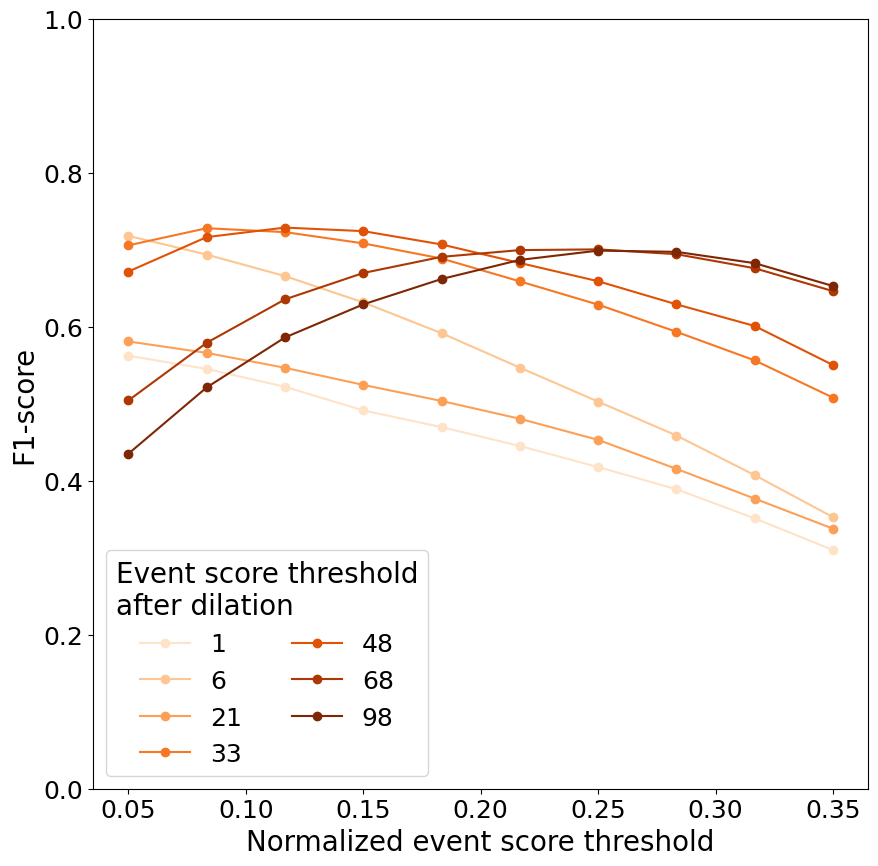

In [72]:
cbar_ticks = np.arange(num_models)

norm_bounds = -1, num_models-1
norm = Normalize(*norm_bounds)
cmap = plt.cm.ScalarMappable(cmap='Oranges', norm=norm)
colors = cmap.get_cmap()(norm(cbar_ticks))

fig, ax = plt.subplots(figsize=(10, 10))
for model_name, thr, c in zip(model, dilation_threshold, colors):
  ax.plot(pred_threshold, f1_score[model_name], 'o-', color=c, label=thr)

ax.set(xlabel='Normalized event score threshold', ylabel='F1-score', ylim=(0, 1))
ax.legend(title='Event score threshold\nafter dilation', title_fontsize=20, ncol=2)
plt.show()

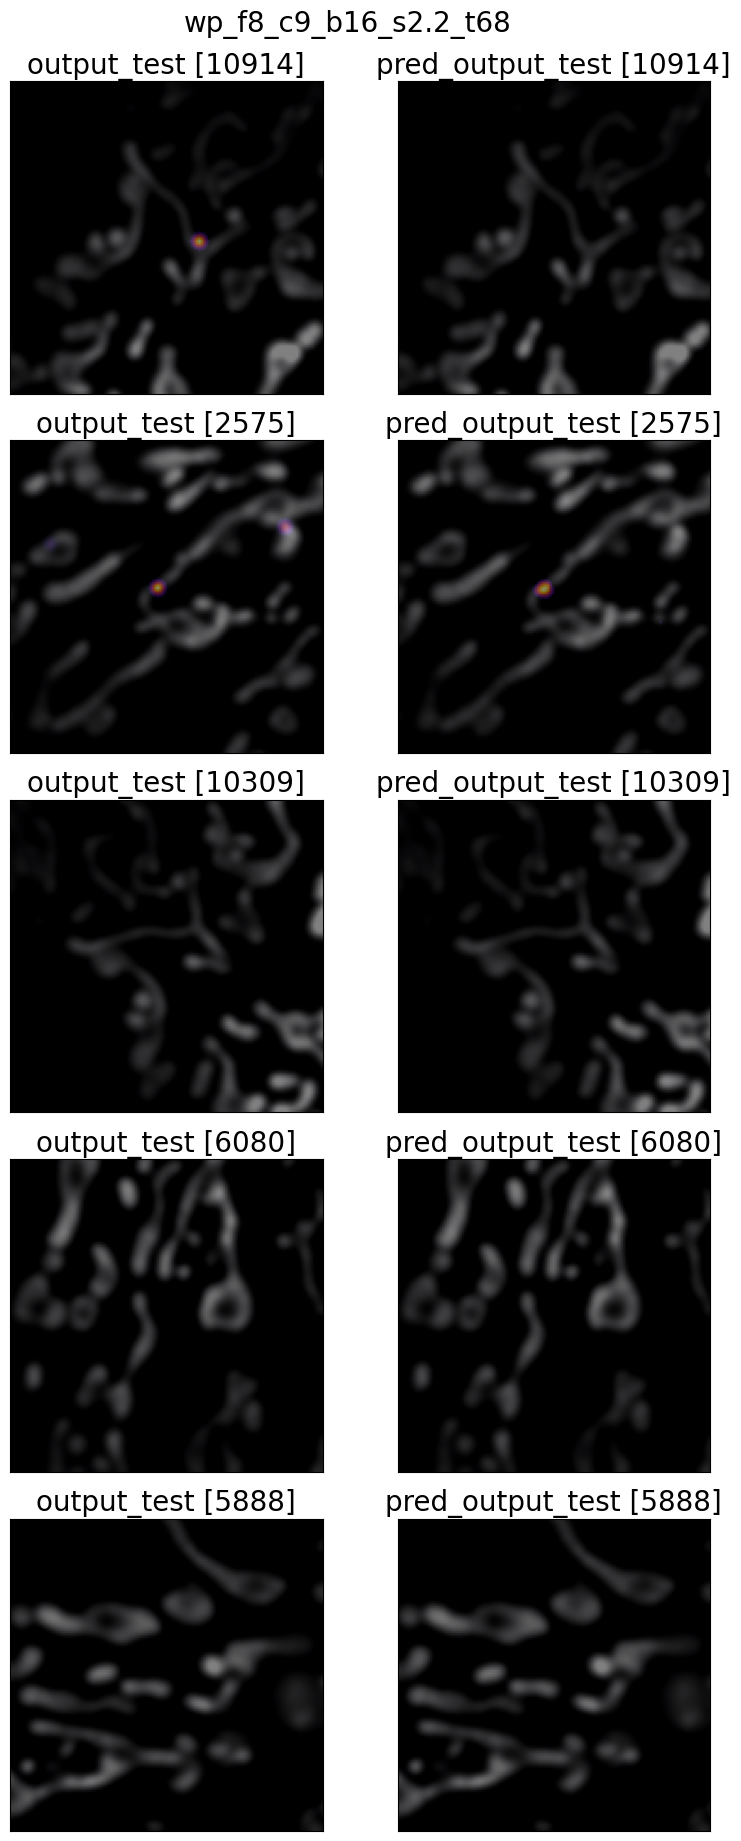

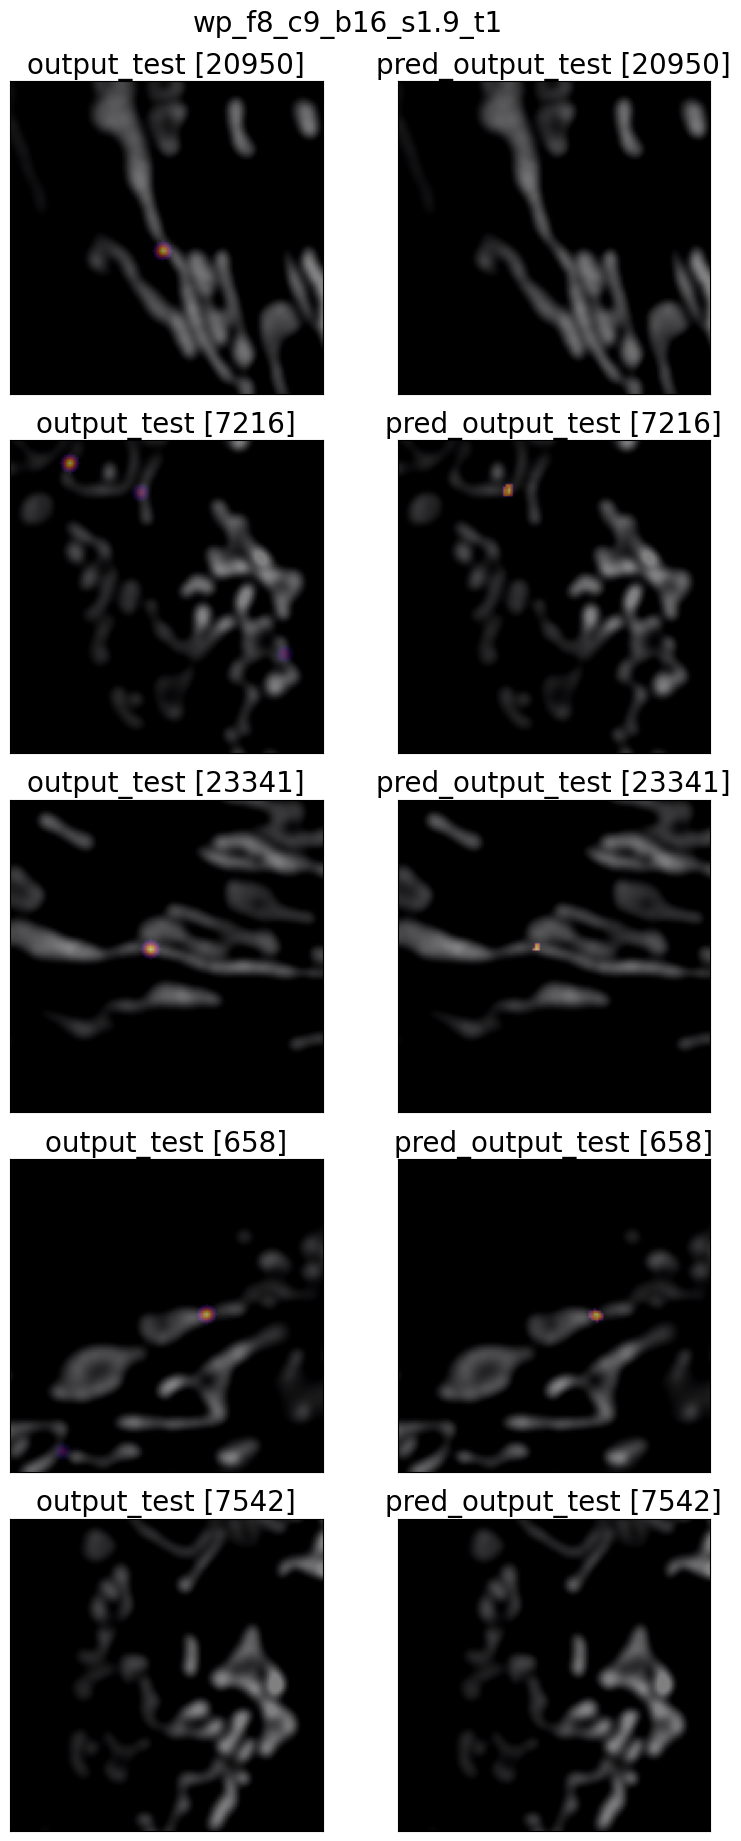

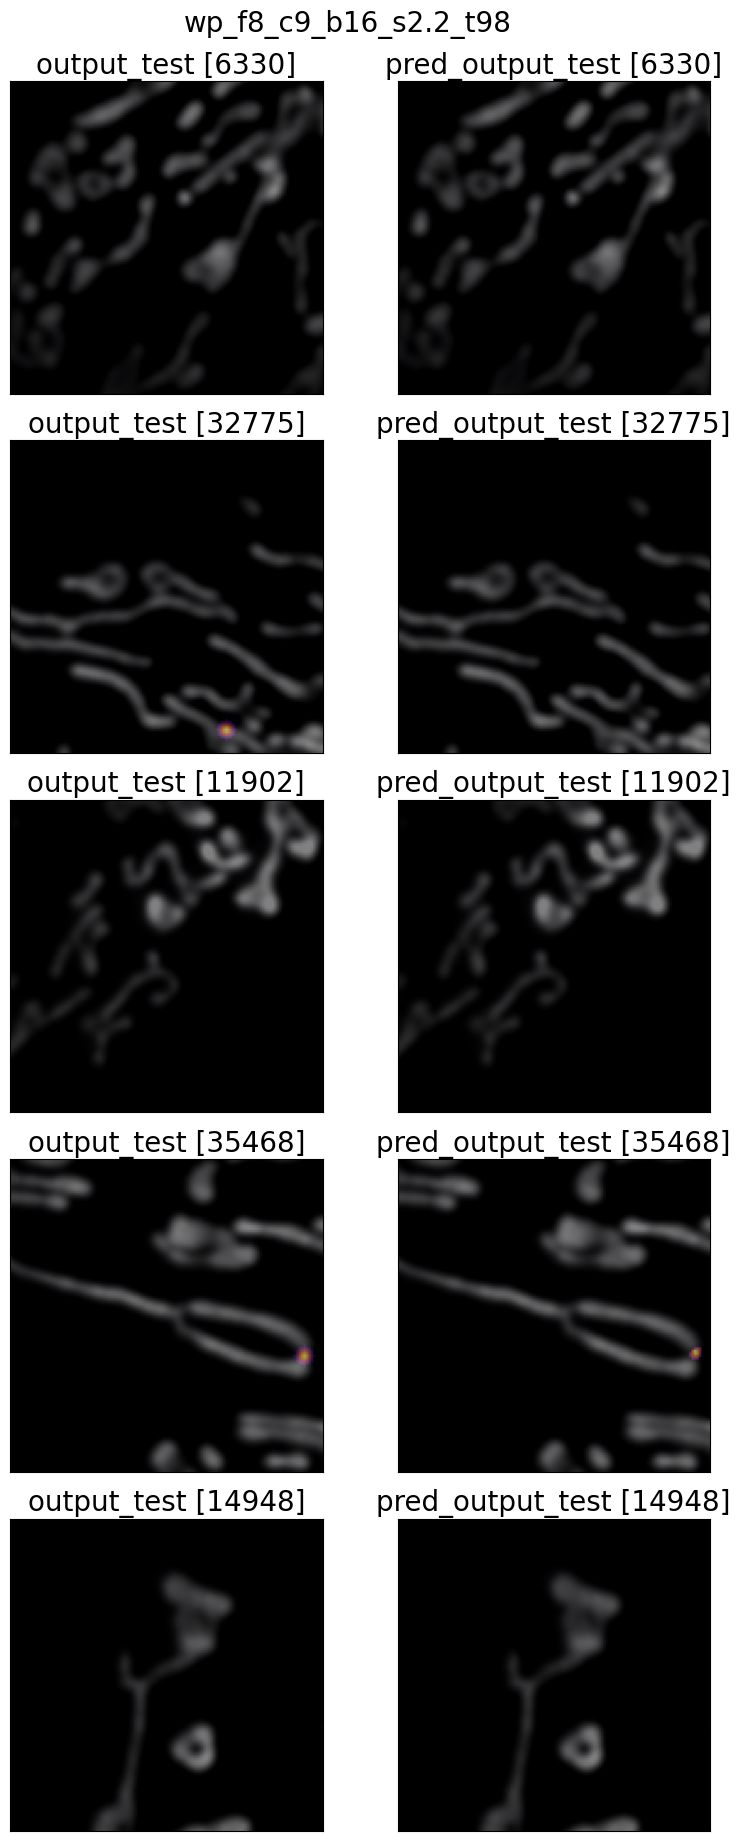

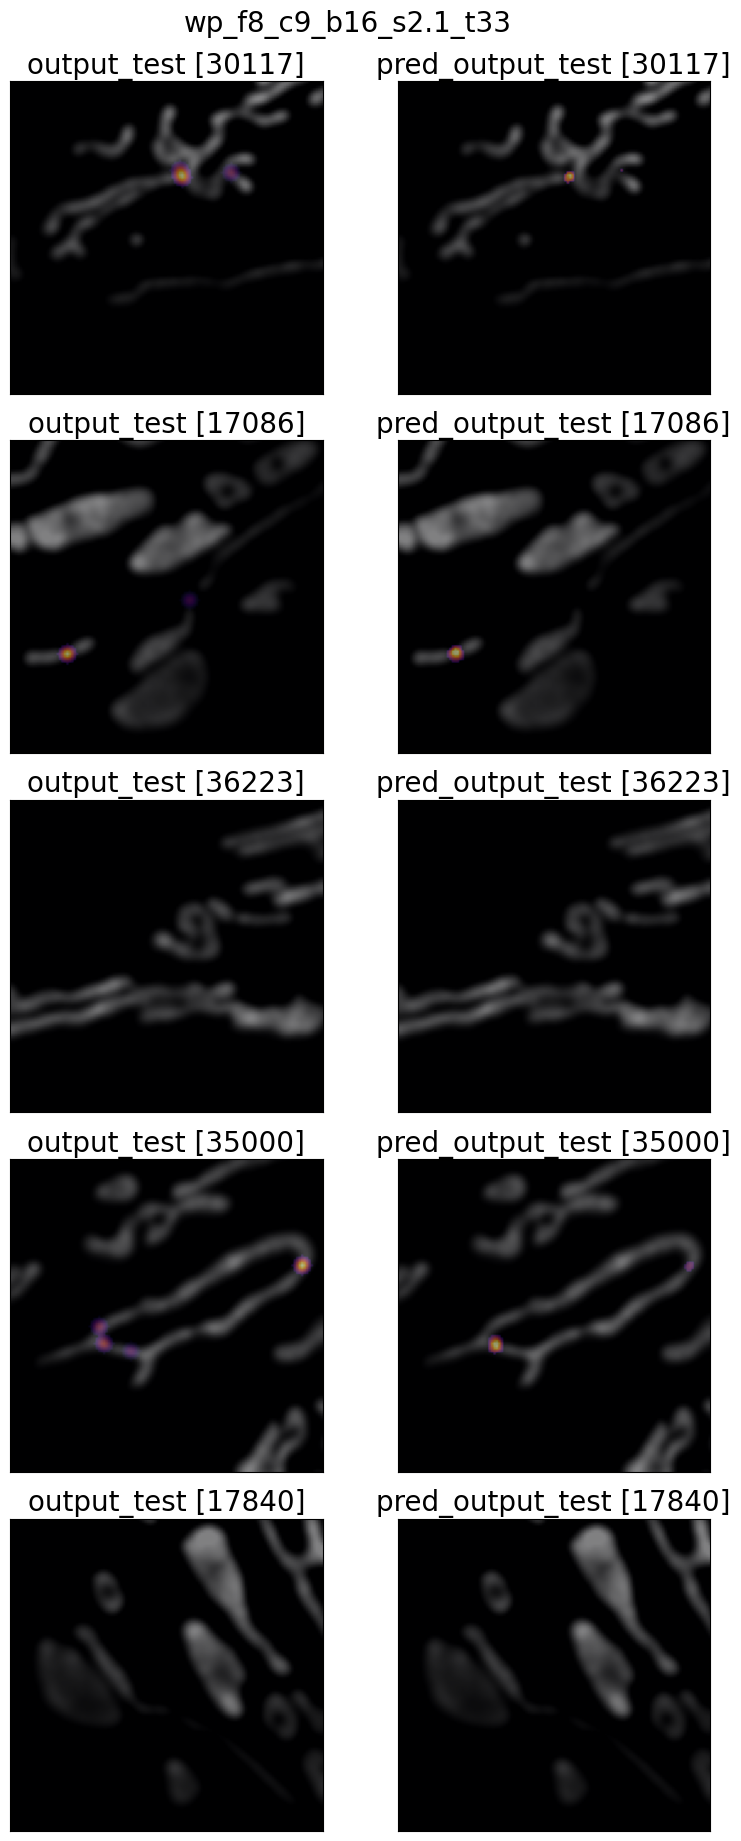

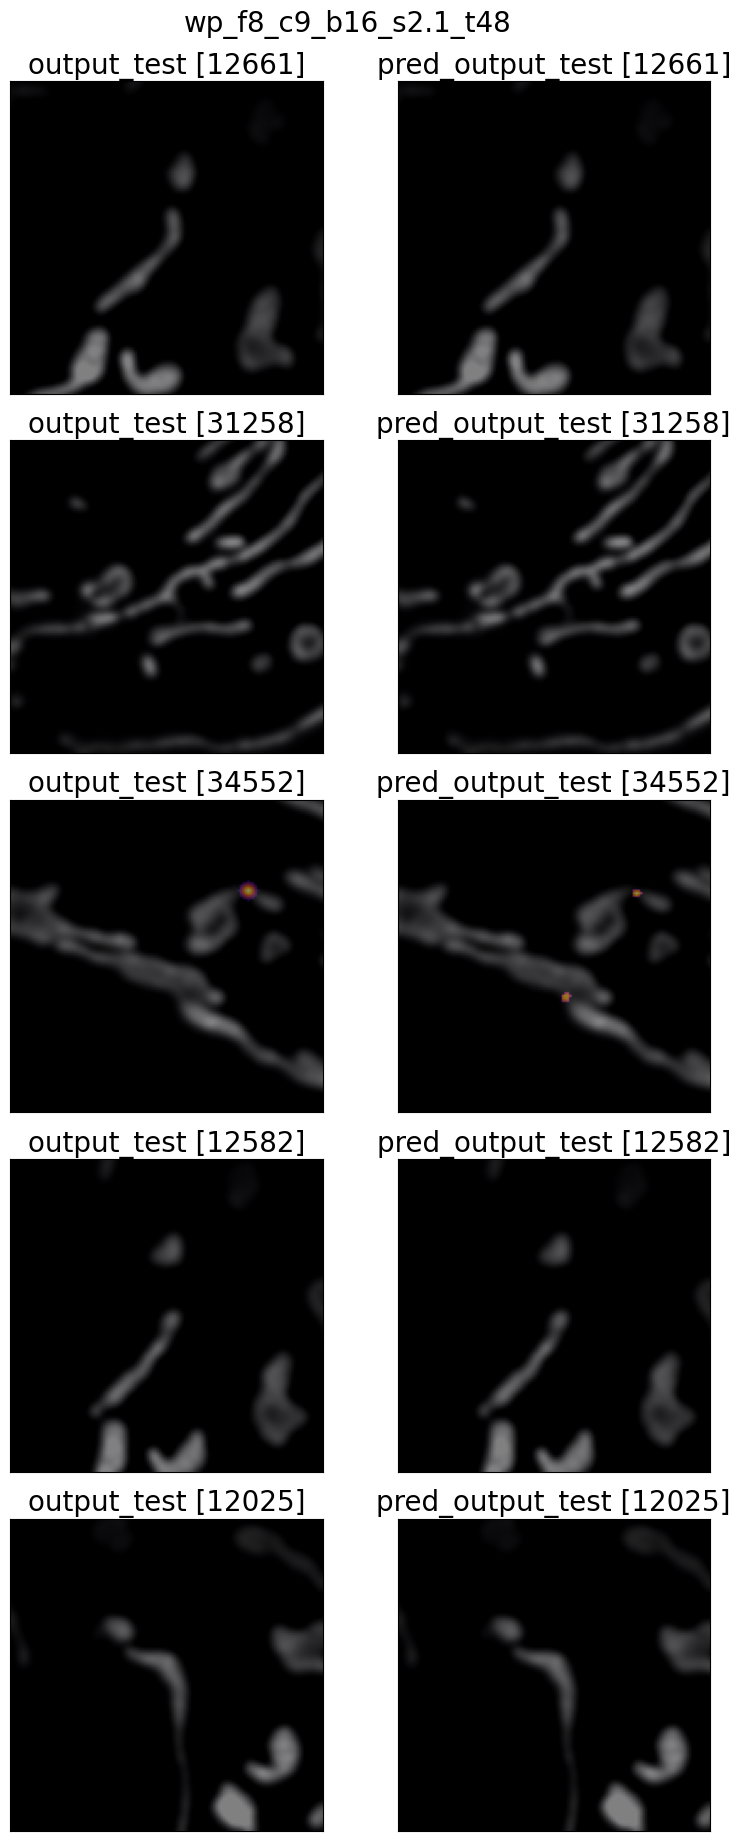

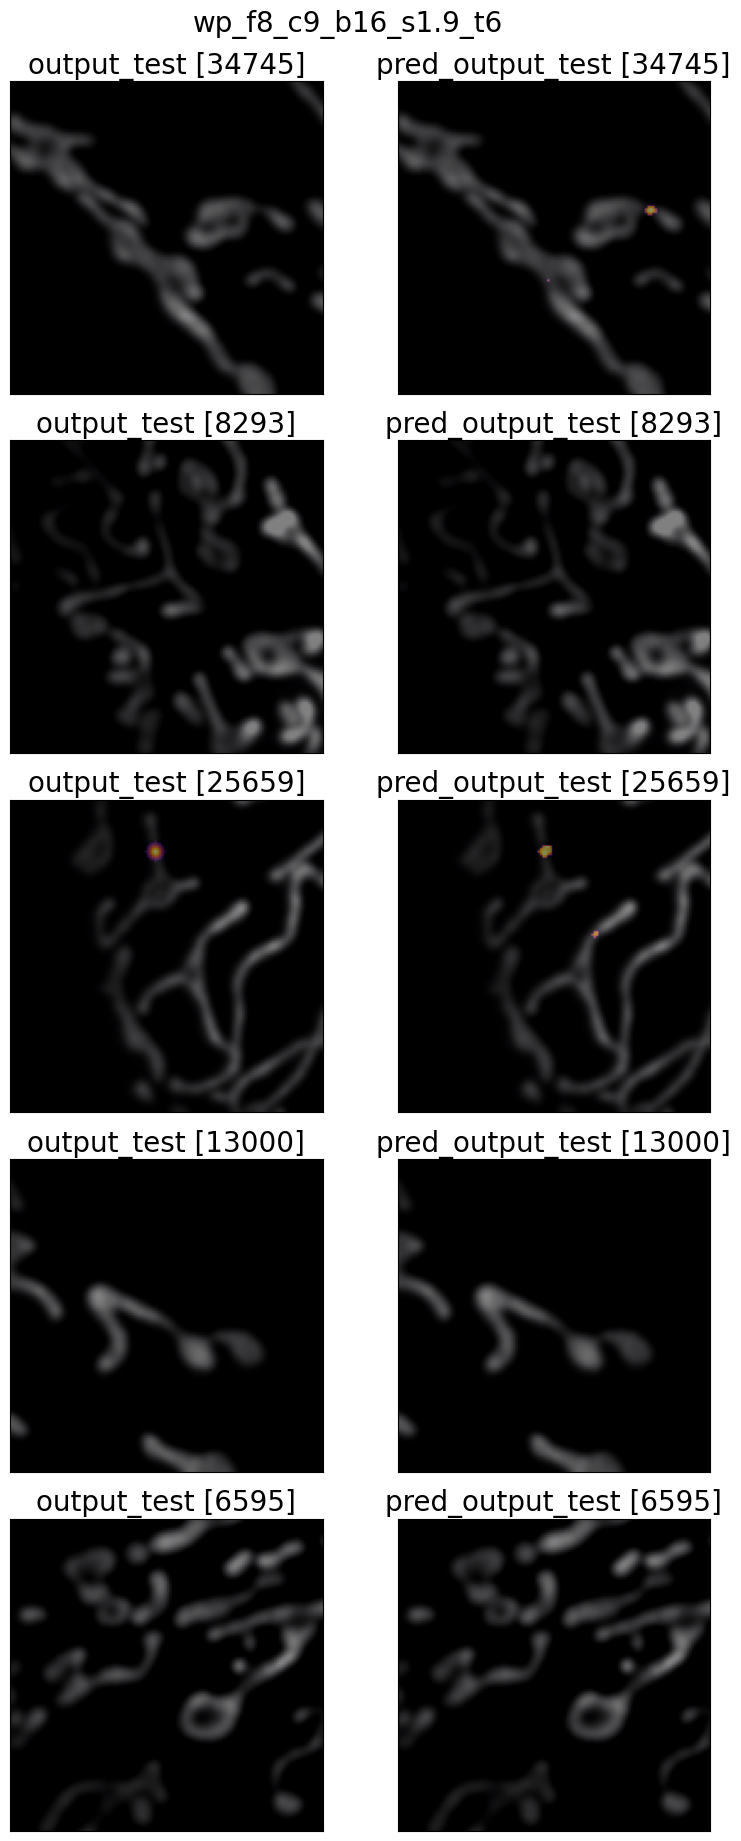

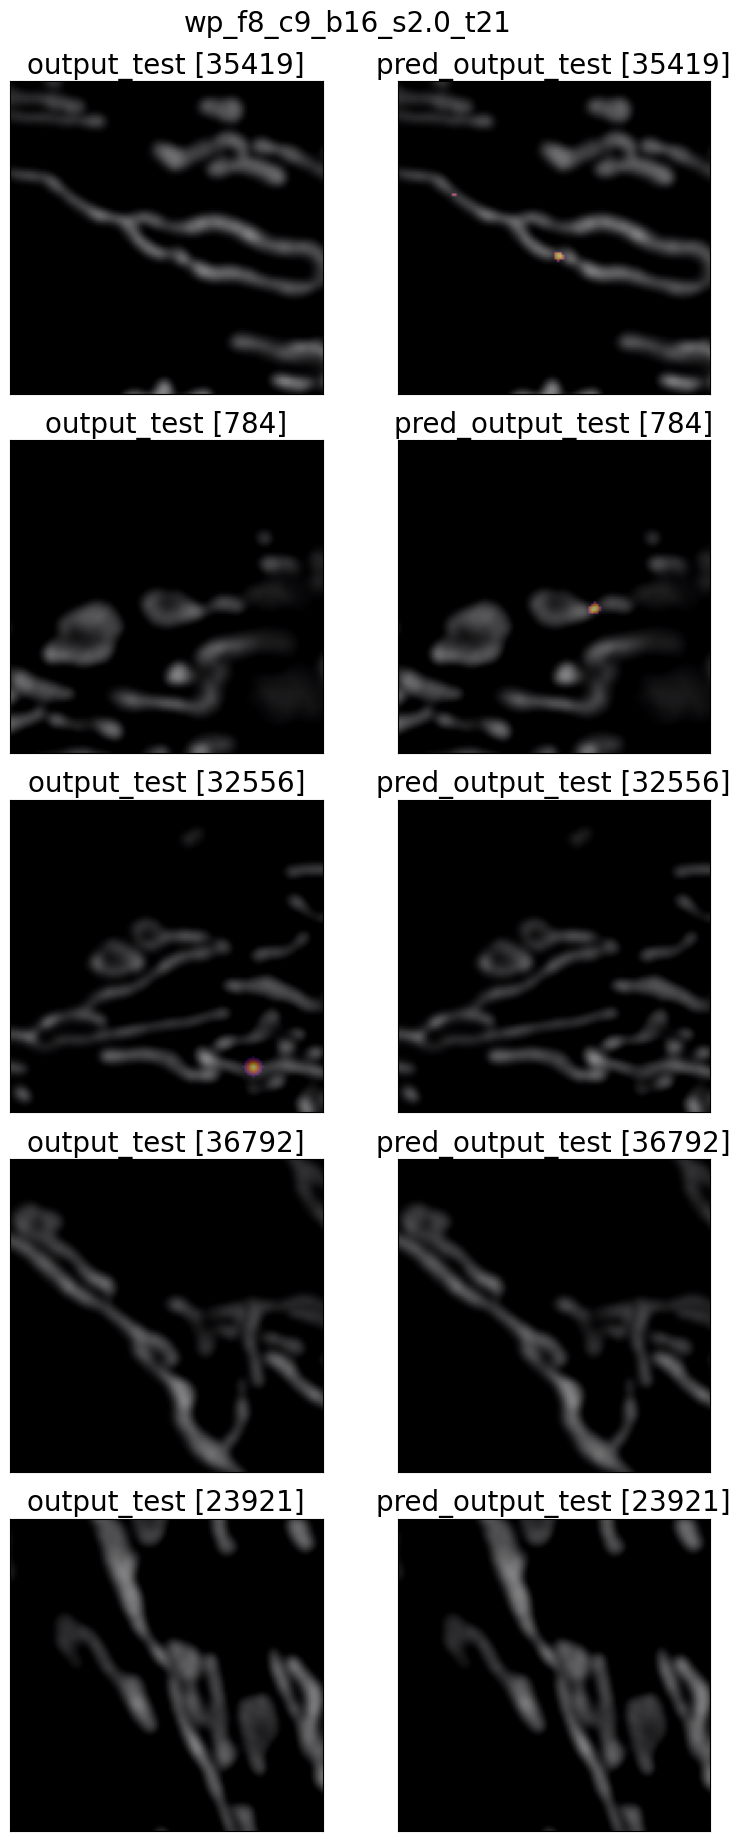

In [73]:
for model_name in folder_name:
  mask = pred_output_test[model_name]>optimal_pred_threshold[model_name]
  plotting.plot_outputs(input_test[model_name], output_test[model_name], 
                        pred_output_test[model_name]*mask, frames_test[model_name], 
                        nb_examples=5, title=model_name, cmap=['gray', 'inferno'])
  plt.show()
  print('\n')

#### Labels binary overlap

In [74]:
fissionStats = {}
for model_name in labels_test:
  print('\nModel name:', model_name)
  fissionStats[model_name] = evaluation.fissionStatsStack(labels_test[model_name], pred_labels_test[model_name])


Model name: wp_f8_c9_b16_s2.2_t68

Model name: wp_f8_c9_b16_s1.9_t1

Model name: wp_f8_c9_b16_s2.2_t98

Model name: wp_f8_c9_b16_s2.1_t33

Model name: wp_f8_c9_b16_s2.1_t48

Model name: wp_f8_c9_b16_s1.9_t6

Model name: wp_f8_c9_b16_s2.0_t21


In [75]:
fissionStats = pd.DataFrame(fissionStats, index=['TP', 'FP', 'FN', 'TP_px', 'FP_px', 'FN_px']).T
fissionStats['precision'] = fissionStats['TP']/(fissionStats['TP']+fissionStats['FP'])
fissionStats['TPR'] = fissionStats['TP']/(fissionStats['TP']+fissionStats['FN'])
fissionStats['FDR'] = fissionStats['FP']/(fissionStats['TP']+fissionStats['FP'])

fissionStats['precision_px'] = fissionStats['TP_px']/(fissionStats['TP_px']+fissionStats['FP_px'])
fissionStats['TPR_px'] = fissionStats['TP_px']/(fissionStats['TP_px']+fissionStats['FN_px'])
fissionStats['FDR_px'] = fissionStats['FP_px']/(fissionStats['TP_px']+fissionStats['FP_px'])

fissionStats = fissionStats.T

/mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Figures/wp_fissionStats.png


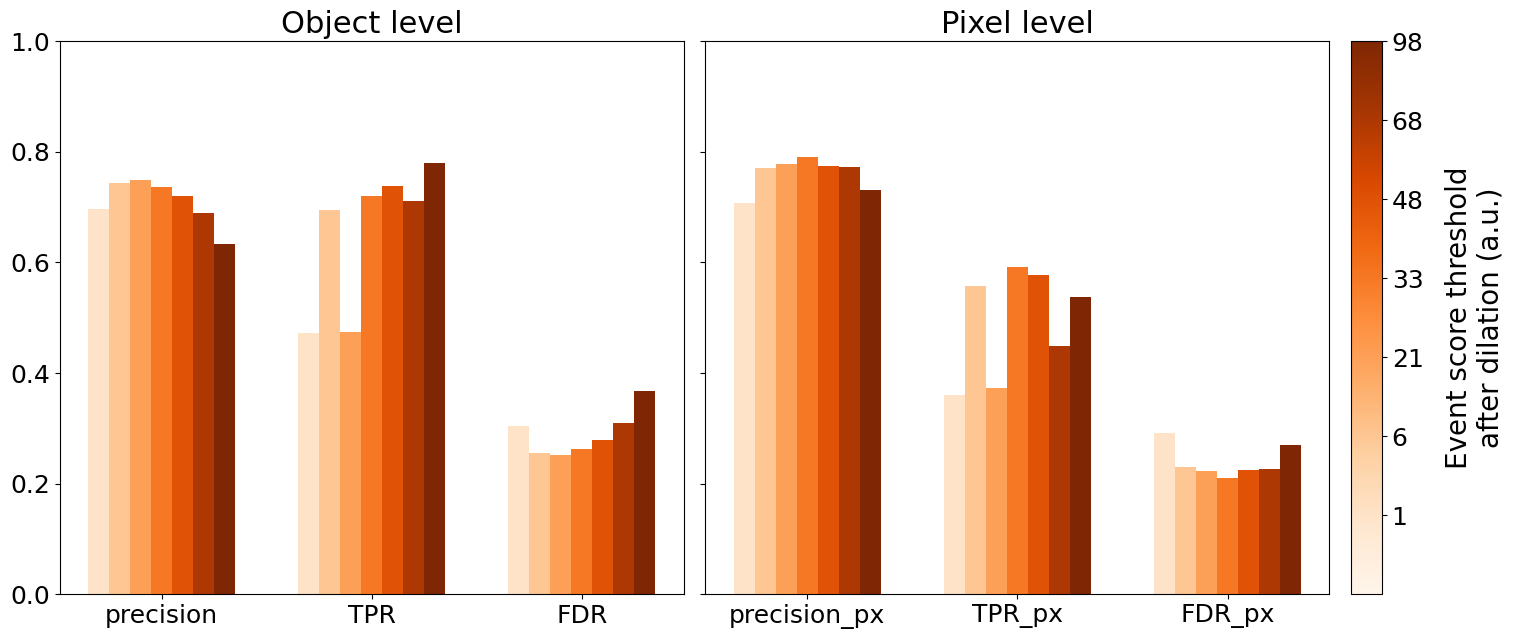

In [76]:
title = 'wp_fissionStats'
filename = base_dir+'Figures/'+title+'.png'
print(filename)

fig = plt.figure(figsize=(7*2, 7))
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 0.05])

axes = []
axes += [fig.add_subplot(gs[0])]
axes += [fig.add_subplot(gs[1])]
cax = fig.add_subplot(gs[2])

plotting.plot_metrics_comparison(fissionStats.loc[['precision', 'TPR', 'FDR']], xscale=2, color=colors, ax=axes[0], ylim=[0, 1], legend=False)  
plotting.plot_metrics_comparison(fissionStats.loc[['precision_px', 'TPR_px', 'FDR_px']], xscale=2, color=colors, ax=axes[1], ylim=[0, 1], legend=False)
axes[1].set_yticklabels([])

for ax, title in zip(axes, ['Object level', 'Pixel level']):
  ax.set_title(title, size=22)
  ax.tick_params(axis='x')
  ax.tick_params(axis='y')

cbar = fig.colorbar(cmap, cax=cax, ticks=cbar_ticks)
cbar.set_ticklabels(dilation_threshold)
cbar.set_label('Event score threshold\nafter dilation (a.u.)', labelpad=15)


plt.tight_layout(pad=0)
fig.subplots_adjust(wspace=0.05, top=0.84, right=0.98)

#plt.show()
fig.savefig(filename)

#### Detection match

In [77]:
det_match = [evaluation.detection_match(output_test[model_name], pred_output_test[model_name]) for model_name in folder_name]

/mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Figures/wp_det_match.png


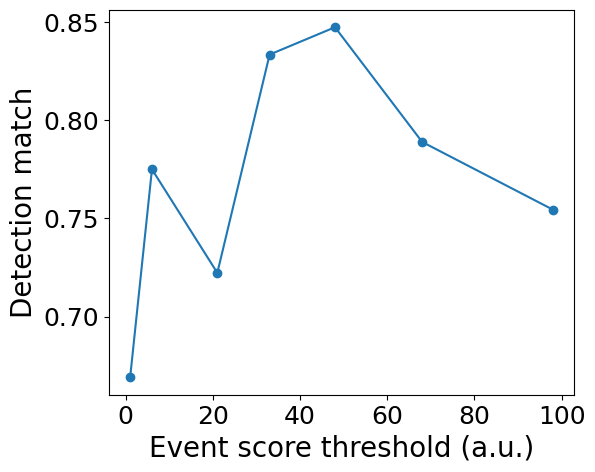

In [78]:
title = 'wp_det_match'
filename = base_dir+'Figures/'+title+'.png'
print(filename)

fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(dilation_threshold, det_match, 'o-')
ax.set(xlabel='Event score threshold (a.u.)', ylabel='Detection match')
#plt.show()
fig.savefig(filename)

### Mito + Drp1 channels as inputs

In [79]:
#Inputs
input_data = util.load_h5(data_path, 'Mito')
input_data = np.stack((input_data, util.load_h5(data_path, 'Drp1')), axis=-1)
print('Inputs'+':', input_data.shape)

dilation_sigma = util.load_pkl(data_path, 'max_optimal_sigma')
dilation_threshold = util.load_pkl(data_path, 'max_intensity_threshold')
num_sigmas = dilation_sigma.shape[0]


Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/Mito.h5
Converting to array

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/Drp1.h5
Converting to array
Inputs: (37000, 128, 128, 2)

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/max_optimal_sigma

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/max_intensity_threshold


In [81]:
#Outputs
folder_name = util.get_filename(model_path, 'multich_wp_f8')
folder_name = [model_name for model_name in folder_name if np.all([tag not in model_name for tag in ['aug', 'temp']])]
folder_name = [str(Path(folder).parts[-1]) for folder in folder_name]
num_models = len(folder_name)

model = util.load_model(model_path, ['model']*num_models, folder_name, as_type=dict)
history = util.load_pkl(model_path, ['history']*num_models, folder_name, as_type=dict)
frames_test = util.load_pkl(model_path, ['frames_test']*num_models, folder_name, as_type=dict)


Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_wp_f8_c9_b16_s2.2_t68/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_wp_f8_c9_b16_s2.2_t98/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_wp_f8_c9_b16_s2.1_t48/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_wp_f8_c9_b16_s2.0_t21/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_wp_f8_c9_b16_s1.9_t6/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_wp_f8_c9_b16_s2.1_t33/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_wp_f8_c9_b16_s1.9_t1/model.h5


Done.

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_wp_f8_c9_b16_s2.2_t68/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_wp_f8_c9_b16_s2.2_t98/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_wp_f8_c9_b16_s2.1_t48/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_wp_f8_c9_b16_s2.0_t21/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_wp_f8_c9_b16_s1.9_t6/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_wp_f8_c9_b16_s2.1_t33/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_wp_f8_c9_b16_s1.9_t1/history
Done.

Loading /mnt/LEB/Scientific_pr

In [82]:
input_test, output_test, pred_output_test = {}, {}, {}
labels_test = {}

for model_name, s, t in zip(folder_name, dilation_sigma, dilation_threshold):
  print('\nModel: %s'%model_name)
  
  #Inputs
  input_test[model_name] = input_data[frames_test[model_name]]
  
  metadata = 's%.1f_t%.i'%(s, t)
  #Outputs
  output_data = util.load_h5(data_path, 'WatProc_'+metadata)
  print('Outputs:', output_data.shape)
  output_test[model_name] = output_data[frames_test[model_name]]
  del output_data
  
  #Labels
  labels = util.load_h5(data_path, 'proc_labels_'+metadata)
  print('Labels:', labels.shape)
  labels_test[model_name] = labels[frames_test[model_name]]
  del labels
  
  pred_output_test[model_name] = evaluation.predict(input_test[model_name], model[model_name])

del input_data


Model: multich_wp_f8_c9_b16_s2.2_t68

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/WatProc_s1.9_t1.h5
Converting to array
Outputs: (37000, 128, 128)

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/proc_labels_s1.9_t1.h5
Converting to array
Labels: (37000, 128, 128)
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Model: multich_wp_f8_c9_b16_s2.2_t98

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/WatProc_s1.9_t6.h5
Converting to array
Outputs: (37000, 128, 128)

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/proc_labels_s1.9_t6.h5
Converting to array
Labels: (37000, 128, 128)
232/232 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step

Model: multich_wp_f8_c9_b16_s2.1_t48

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/WatProc_s2.0_t21.h5
Converting to array
Outputs

#### Threshold optimization

In [83]:
pred_threshold = np.linspace(0.05, 0.35, 10, endpoint=True)
f1_score = {}
optimal_pred_threshold = {}
pred_labels_test = {}

for model_name in model:
  print("Processing %s" %model_name)
  f1_score[model_name] = evaluation.get_f1_curve(labels_test[model_name], pred_output_test[model_name], pred_threshold)
  optimal_pred_threshold[model_name] = evaluation.get_optimal_threshold(pred_threshold, f1_score[model_name])
  pred_labels_test[model_name] = evaluation.label(pred_output_test[model_name], threshold=optimal_pred_threshold[model_name])
  print('\n')
  
util.save_pkl(f1_score, model_path, 'multich_wp_f1_score')
util.save_pkl(optimal_pred_threshold, model_path, 'multich_wp_optimal_pred_threshold')

Processing multich_wp_f8_c9_b16_s2.2_t68


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:54<00:00,  5.48s/it]




Processing multich_wp_f8_c9_b16_s2.2_t98


100%|██████████| 10/10 [00:51<00:00,  5.12s/it]




Processing multich_wp_f8_c9_b16_s2.1_t48


100%|██████████| 10/10 [00:49<00:00,  4.98s/it]




Processing multich_wp_f8_c9_b16_s2.0_t21


100%|██████████| 10/10 [00:46<00:00,  4.60s/it]




Processing multich_wp_f8_c9_b16_s1.9_t6


100%|██████████| 10/10 [00:44<00:00,  4.41s/it]




Processing multich_wp_f8_c9_b16_s2.1_t33


100%|██████████| 10/10 [00:40<00:00,  4.05s/it]




Processing multich_wp_f8_c9_b16_s1.9_t1


100%|██████████| 10/10 [00:37<00:00,  3.78s/it]





Saving /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_wp_f1_score
Done.

Saving /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_wp_optimal_pred_threshold
Done.


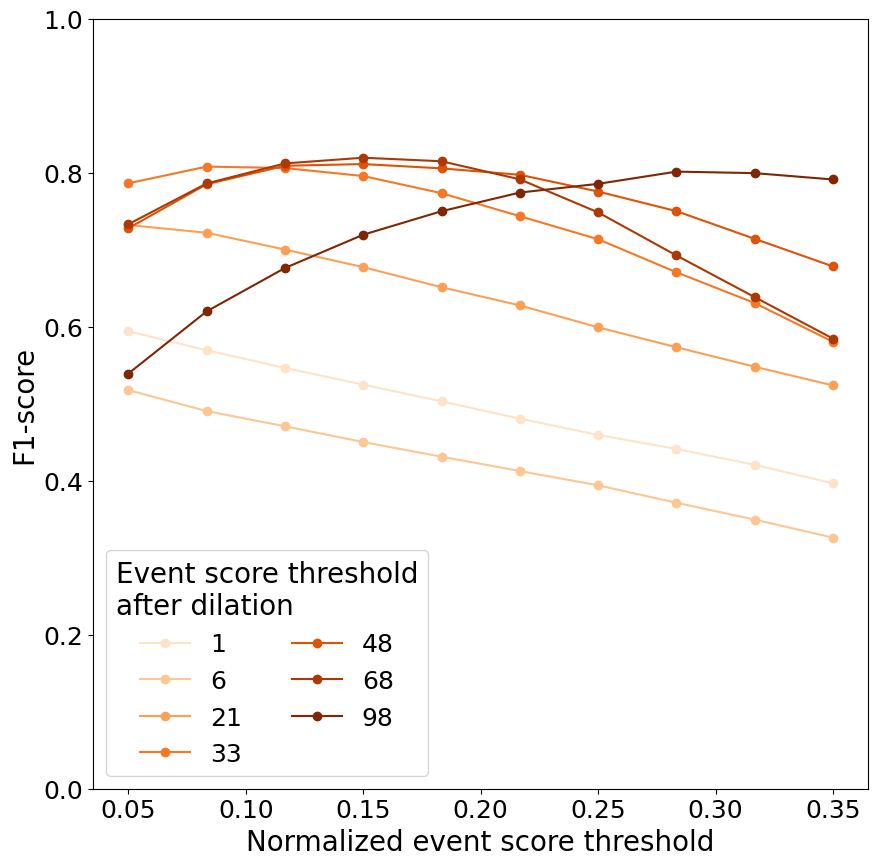

In [84]:
cbar_ticks = np.arange(num_models)

norm_bounds = -1, num_models-1
norm = Normalize(*norm_bounds)
cmap = plt.cm.ScalarMappable(cmap='Oranges', norm=norm)
colors = cmap.get_cmap()(norm(cbar_ticks))

fig, ax = plt.subplots(figsize=(10, 10))
for model_name, thr, c in zip(model, dilation_threshold, colors):
  ax.plot(pred_threshold, f1_score[model_name], 'o-', color=c, label=thr)

ax.set(xlabel='Normalized event score threshold', ylabel='F1-score', ylim=(0, 1))
ax.legend(title='Event score threshold\nafter dilation', title_fontsize=20, ncol=2)
plt.show()

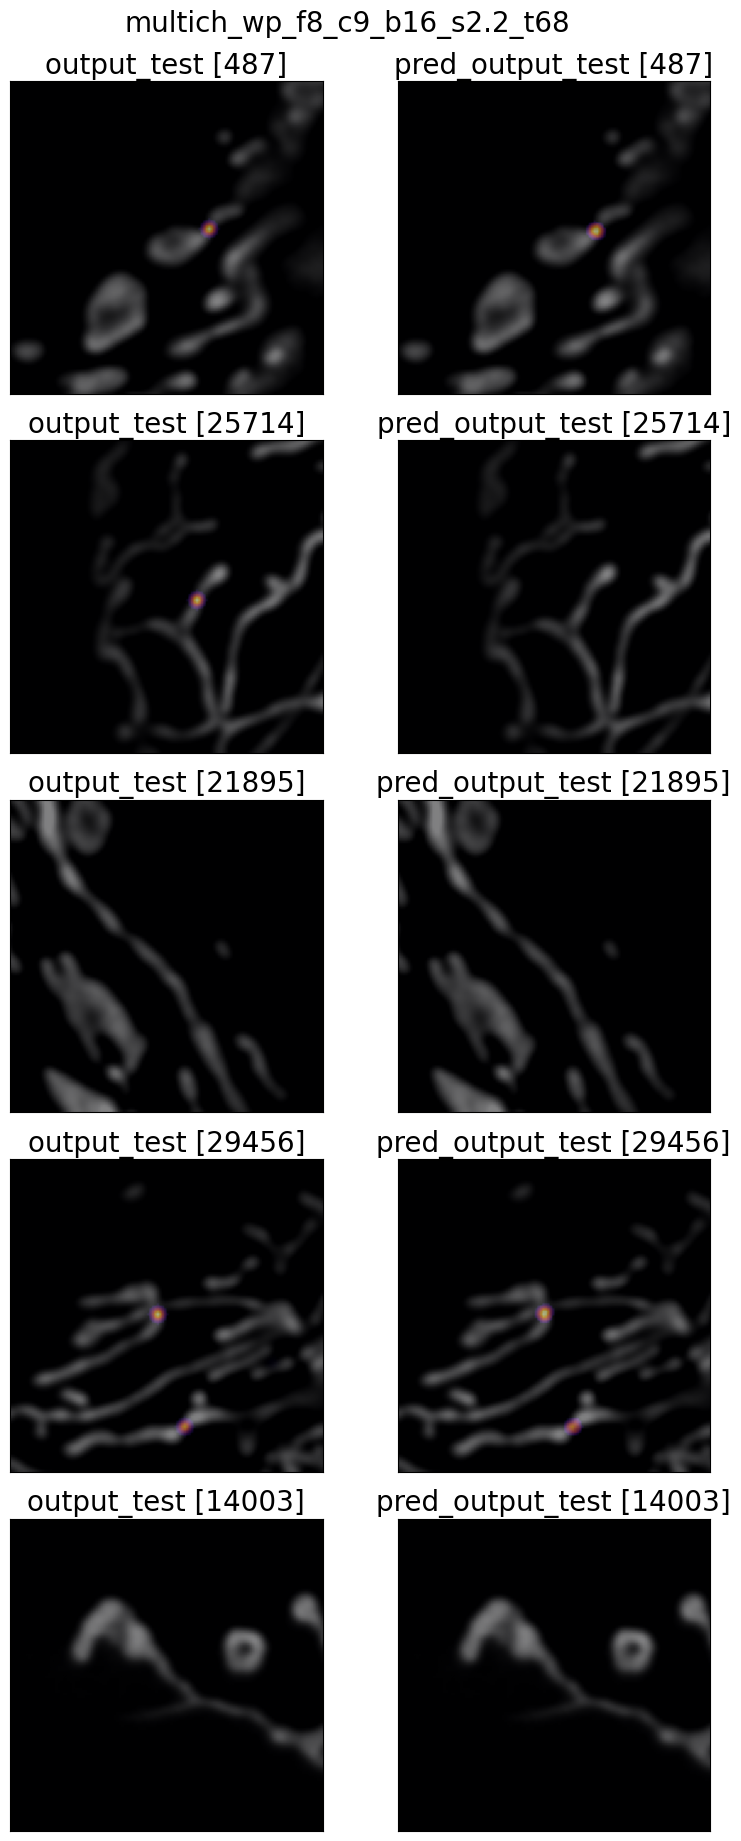

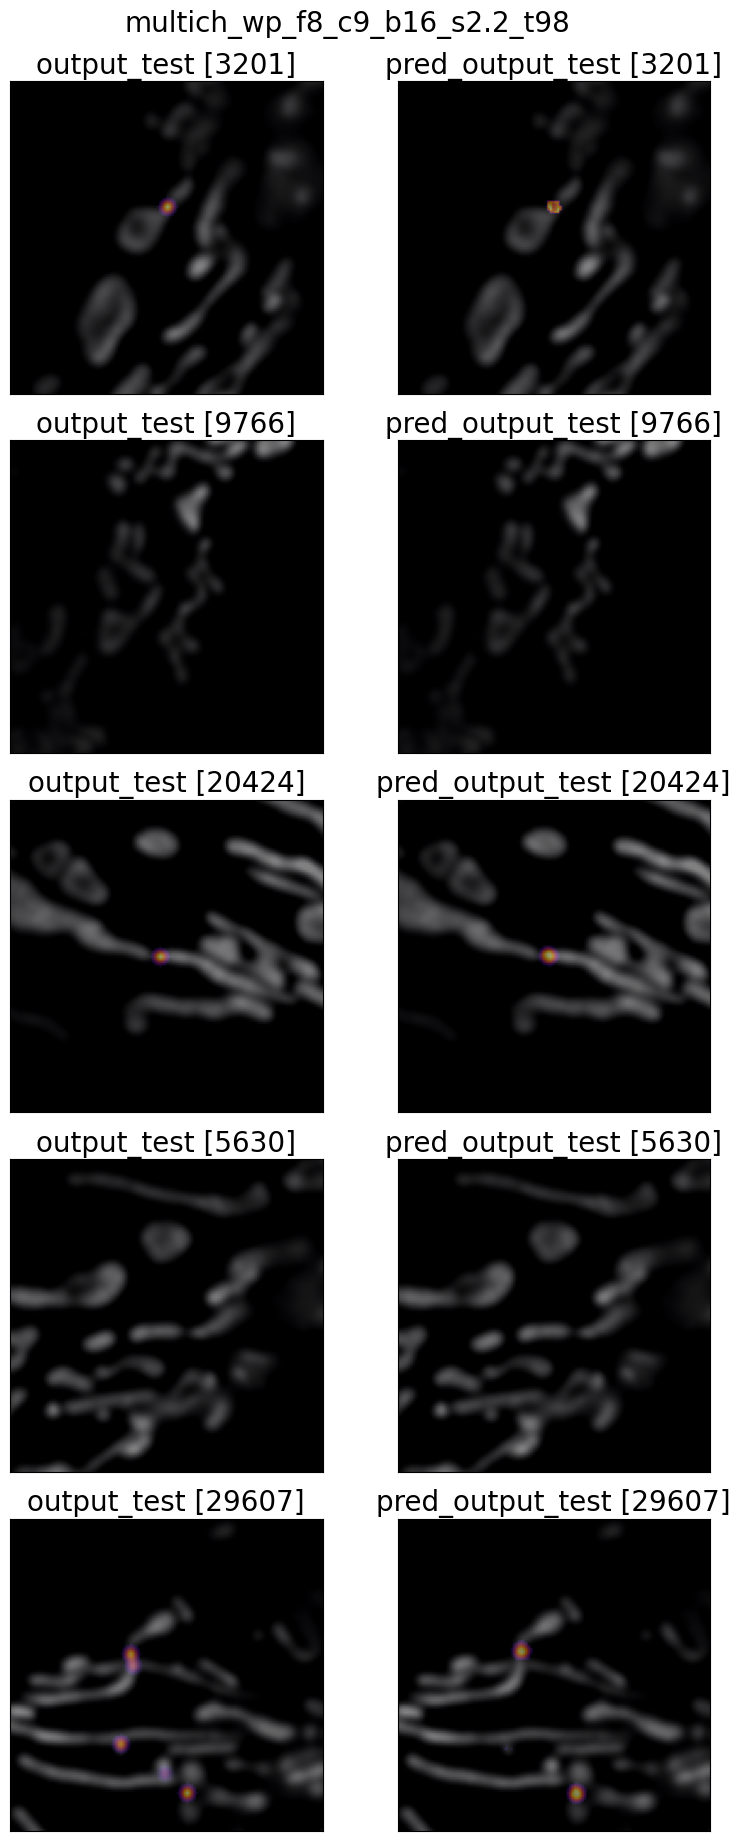

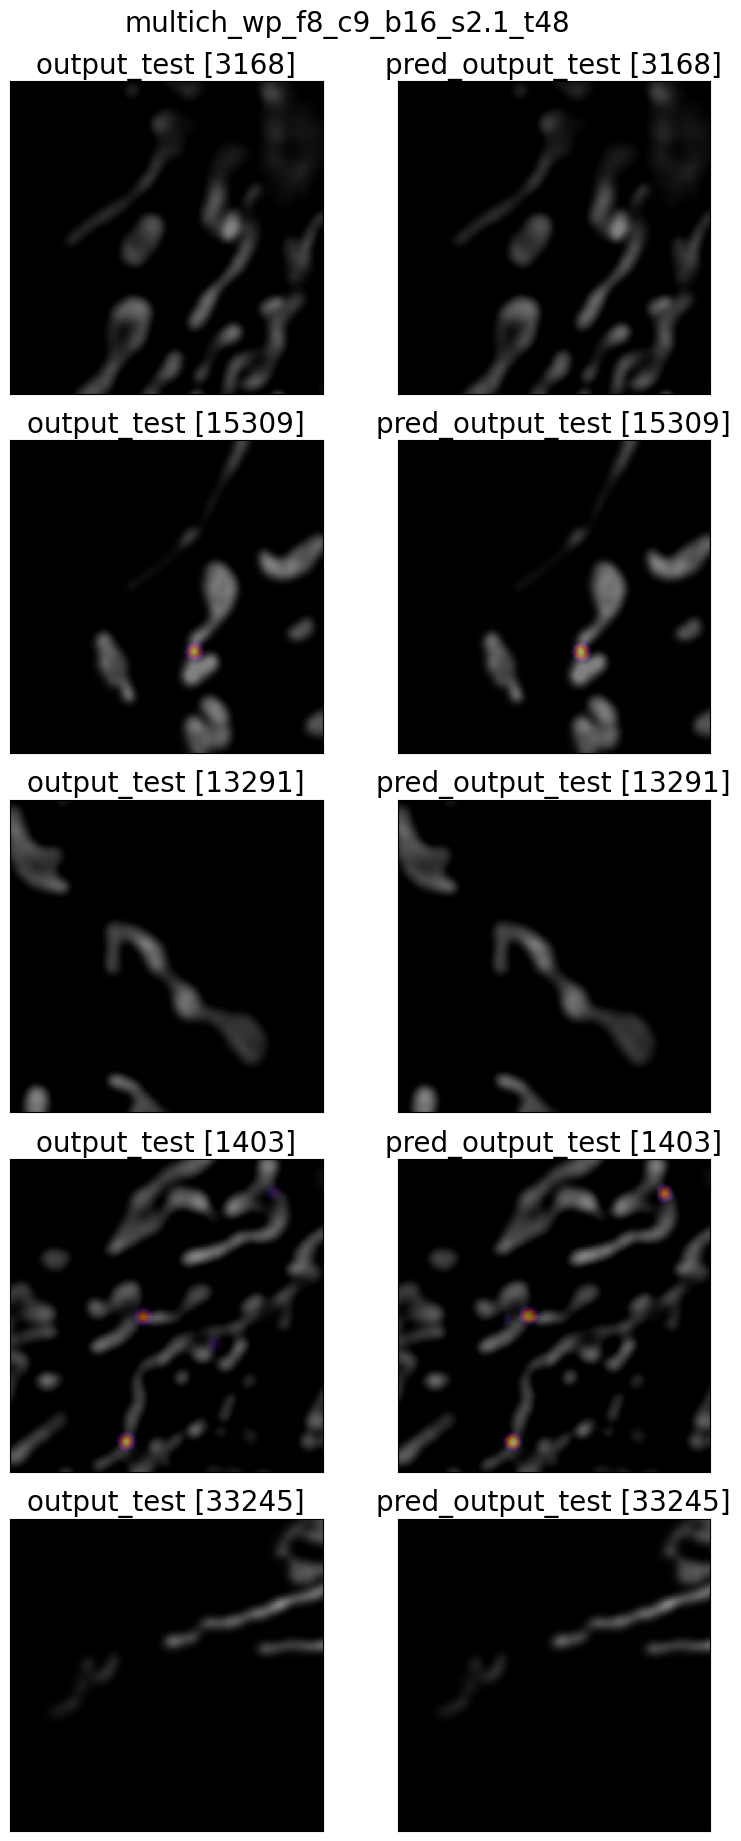

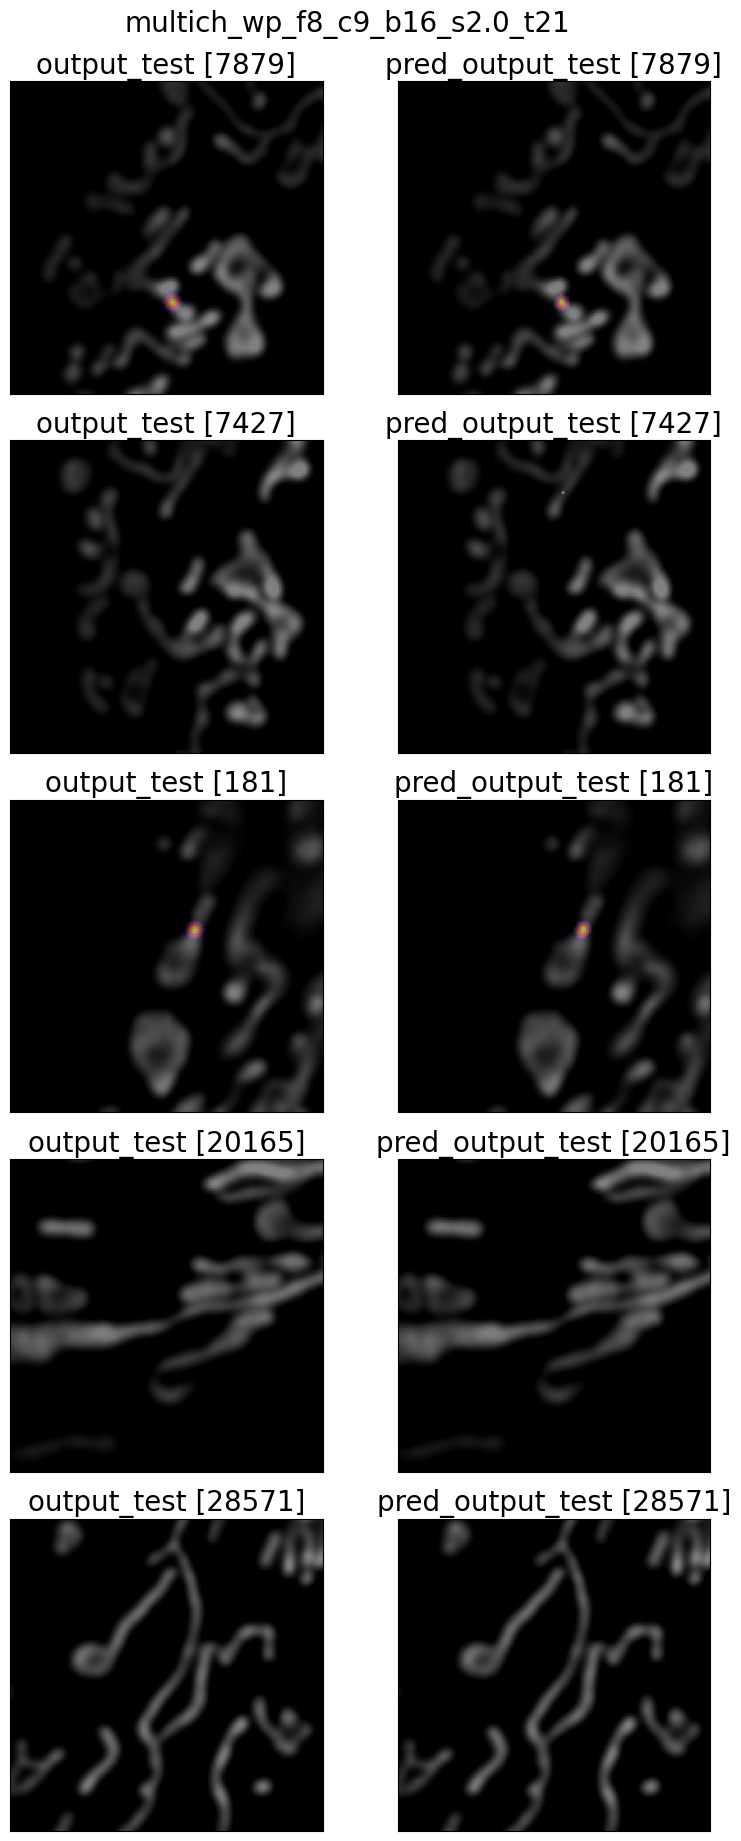

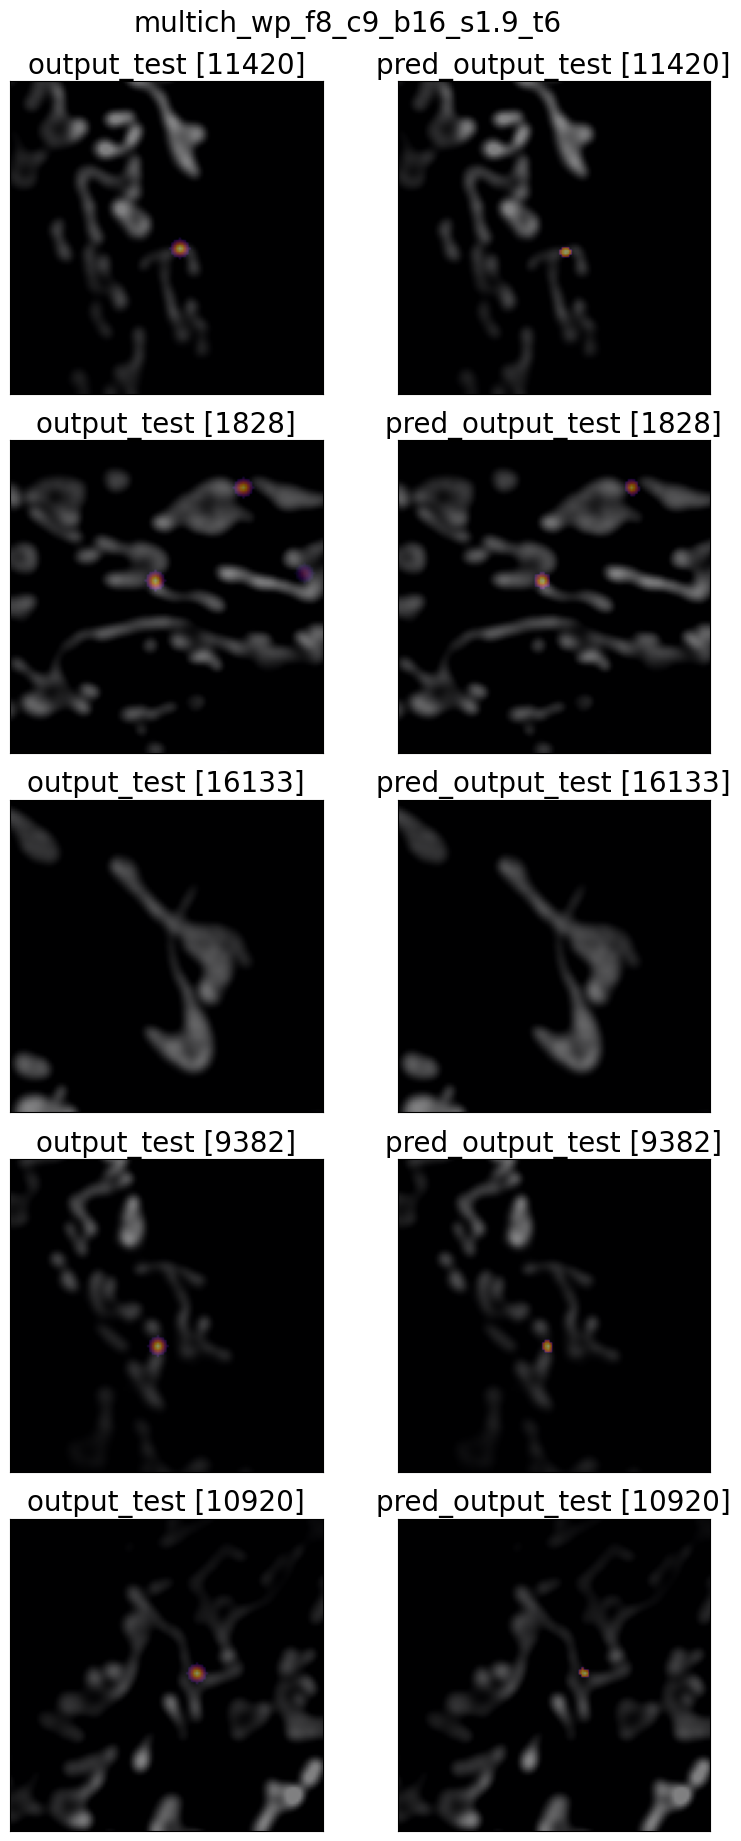

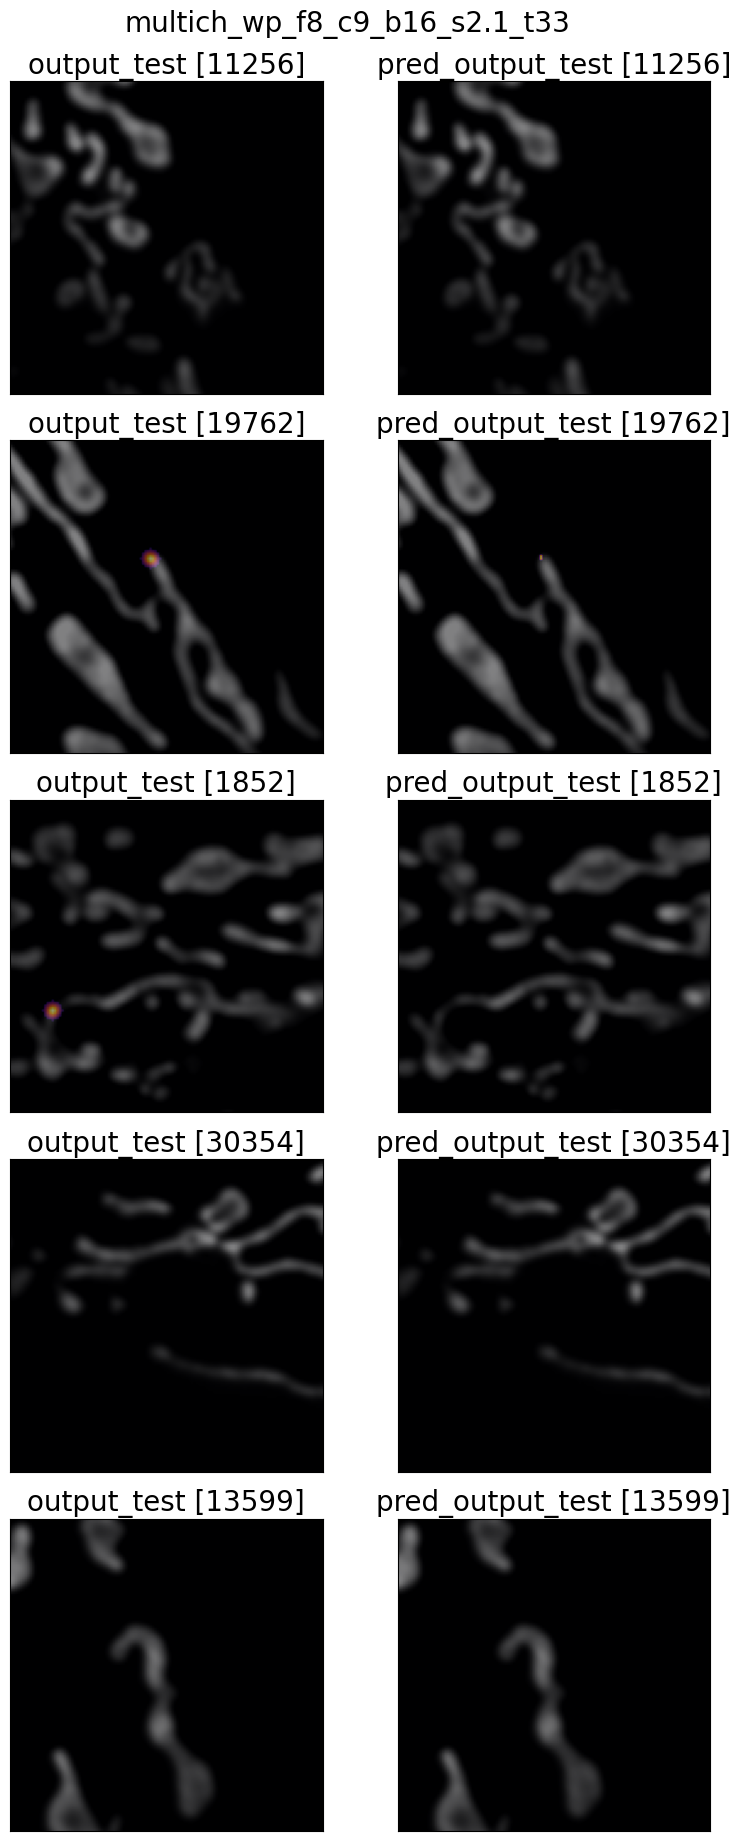

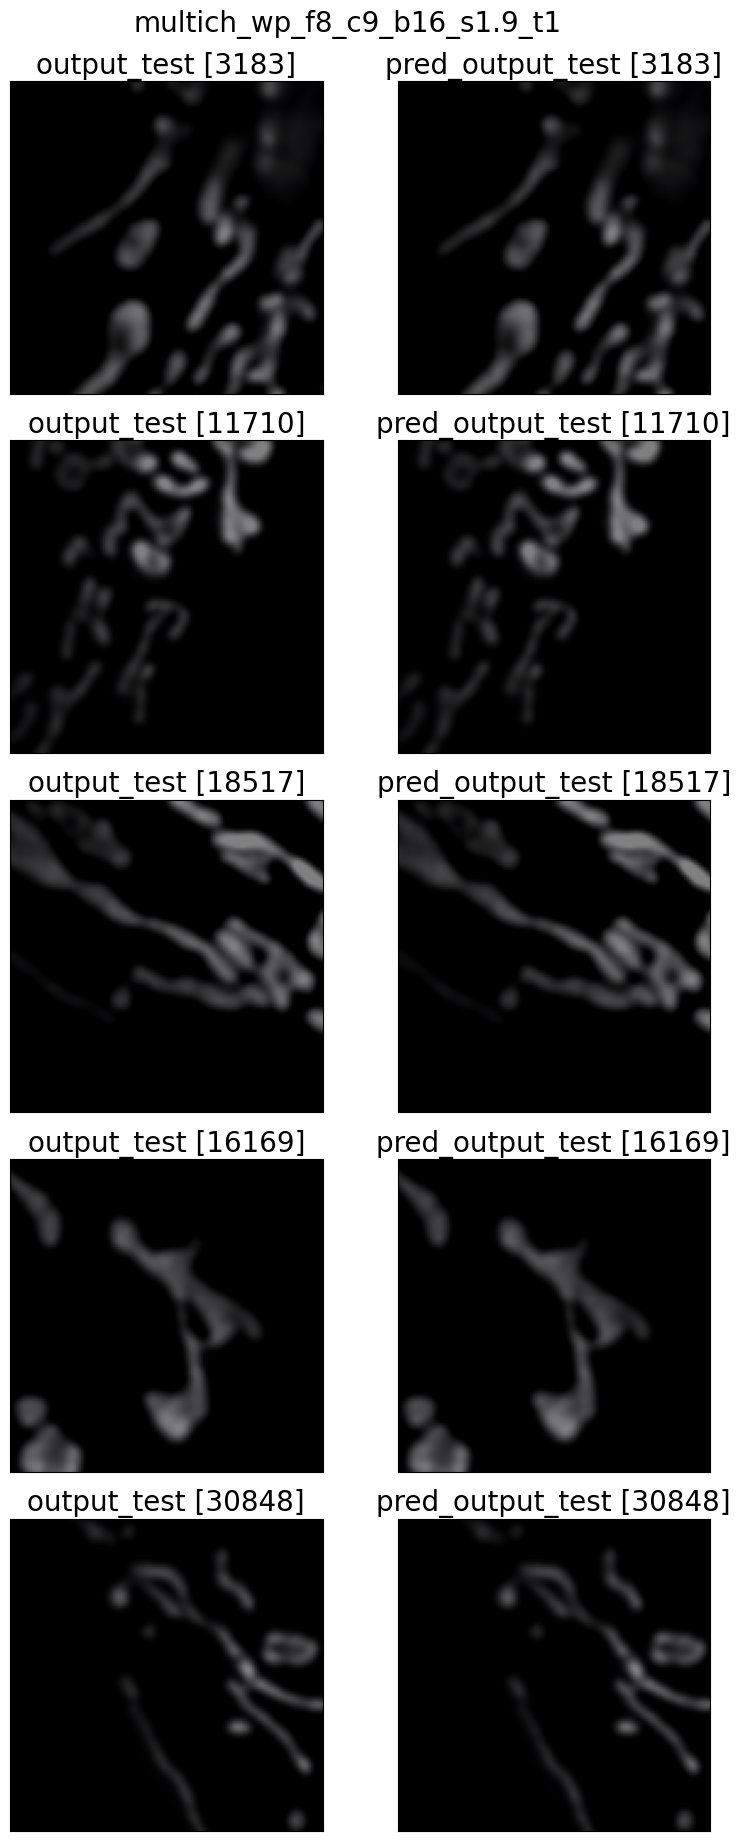

In [85]:
for model_name in folder_name:
  mask = pred_output_test[model_name]>optimal_pred_threshold[model_name]
  plotting.plot_outputs(input_test[model_name][:, :, :, 0], output_test[model_name], 
                        pred_output_test[model_name]*mask, frames_test[model_name], 
                        nb_examples=5, title=model_name, cmap=['gray', 'inferno'])
  plt.show()
  print('\n')

#### Labels binary overlap

In [86]:
fissionStats = {}
for model_name in labels_test:
  print('\nModel name:', model_name)
  fissionStats[model_name] = evaluation.fissionStatsStack(labels_test[model_name], pred_labels_test[model_name])


Model name: multich_wp_f8_c9_b16_s2.2_t68

Model name: multich_wp_f8_c9_b16_s2.2_t98

Model name: multich_wp_f8_c9_b16_s2.1_t48

Model name: multich_wp_f8_c9_b16_s2.0_t21

Model name: multich_wp_f8_c9_b16_s1.9_t6

Model name: multich_wp_f8_c9_b16_s2.1_t33

Model name: multich_wp_f8_c9_b16_s1.9_t1


In [87]:
fissionStats = pd.DataFrame(fissionStats, index=['TP', 'FP', 'FN', 'TP_px', 'FP_px', 'FN_px']).T
fissionStats['precision'] = fissionStats['TP']/(fissionStats['TP']+fissionStats['FP'])
fissionStats['TPR'] = fissionStats['TP']/(fissionStats['TP']+fissionStats['FN'])
fissionStats['FDR'] = fissionStats['FP']/(fissionStats['TP']+fissionStats['FP'])

fissionStats['precision_px'] = fissionStats['TP_px']/(fissionStats['TP_px']+fissionStats['FP_px'])
fissionStats['TPR_px'] = fissionStats['TP_px']/(fissionStats['TP_px']+fissionStats['FN_px'])
fissionStats['FDR_px'] = fissionStats['FP_px']/(fissionStats['TP_px']+fissionStats['FP_px'])

fissionStats = fissionStats.T

/mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Figures/multich_wp_fissionStats.png


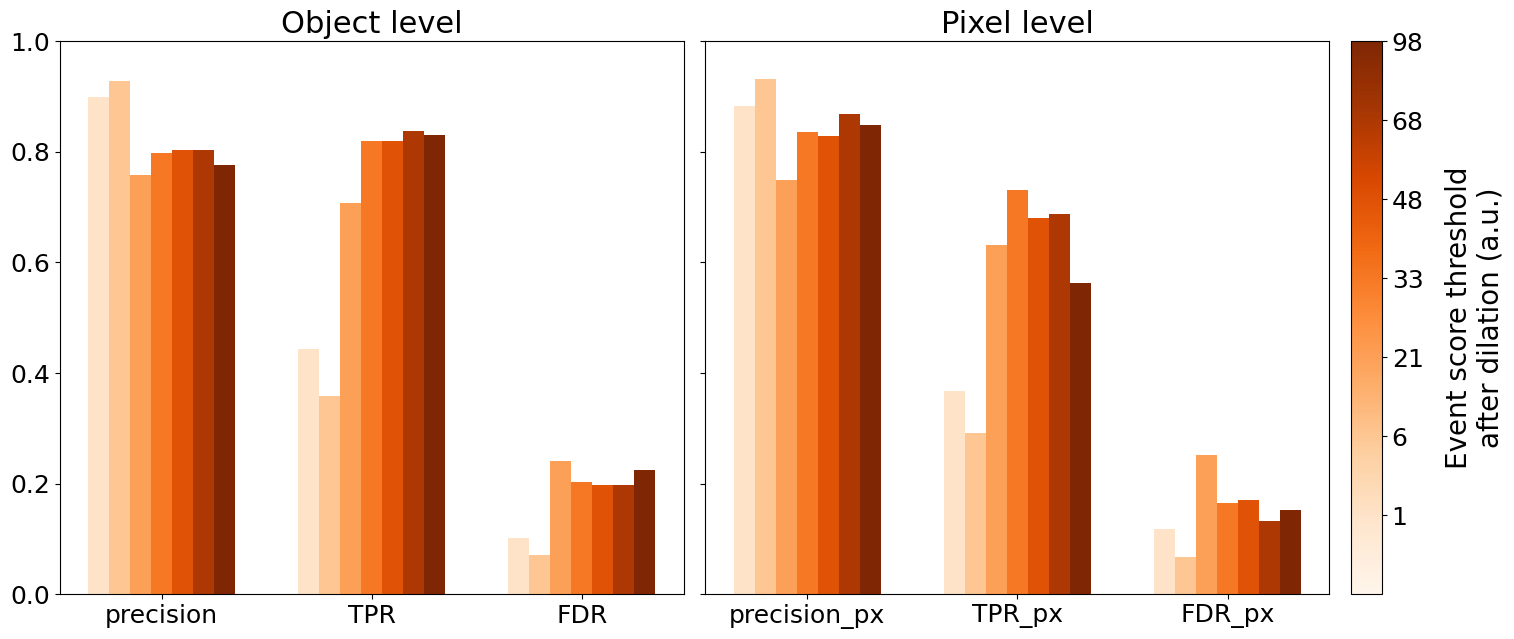

In [88]:
title = 'multich_wp_fissionStats'
filename = base_dir+'Figures/'+title+'.png'
print(filename)

fig = plt.figure(figsize=(7*2, 7))
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 0.05])

axes = []
axes += [fig.add_subplot(gs[0])]
axes += [fig.add_subplot(gs[1])]
cax = fig.add_subplot(gs[2])

plotting.plot_metrics_comparison(fissionStats.loc[['precision', 'TPR', 'FDR']], xscale=2, color=colors, ax=axes[0], ylim=[0, 1], legend=False)  
plotting.plot_metrics_comparison(fissionStats.loc[['precision_px', 'TPR_px', 'FDR_px']], xscale=2, color=colors, ax=axes[1], ylim=[0, 1], legend=False)
axes[1].set_yticklabels([])

for ax, title in zip(axes, ['Object level', 'Pixel level']):
  ax.set_title(title, size=22)
  ax.tick_params(axis='x')
  ax.tick_params(axis='y')

cbar = fig.colorbar(cmap, cax=cax, ticks=cbar_ticks)
cbar.set_ticklabels(dilation_threshold)
cbar.set_label('Event score threshold\nafter dilation (a.u.)', labelpad=15)


plt.tight_layout(pad=0)
fig.subplots_adjust(wspace=0.05, top=0.84, right=0.98)

#plt.show()
fig.savefig(filename)

In [89]:
fissionStats

multich_wp_f8_c9_b16_s2.2_t68  multich_wp_f8_c9_b16_s2.2_t98  \
TP                              3785.000000                    2691.000000   
FP                               428.000000                     208.000000   
FN                              4743.000000                    4806.000000   
TP_px                         131825.000000                   94156.000000   
FP_px                          17634.000000                    6866.000000   
FN_px                         227310.000000                  229542.000000   
precision                          0.898410                       0.928251   
TPR                                0.443832                       0.358944   
FDR                                0.101590                       0.071749   
precision_px                       0.882014                       0.932035   
TPR_px                             0.367063                       0.290876   
FDR_px                             0.117986                       0.067965   

              multich_wp_f8_c9_b16_s2.1_t48  multich_wp_f8_c9_b16_s2.0_t21  \
TP                              4362.000000                    4106.000000   
FP                              1391.000000                    1044.000000   
FN                              1802.000000                     908.000000   
TP_px                         148419.000000                  118157.000000   
FP_px                          49973.000000                   23241.000000   
FN_px                          86993.000000                   43450.000000   
precision                          0.758213                       0.797282   
TPR                                0.707657                       0.818907   
FDR                                0.241787                       0.202718   
precision_px                       0.748110                       0.835634   
TPR_px                             0.630465                       0.731138   
FDR_px                             0.251890                       0.164366   

              multich_wp_f8_c9_b16_s1.9_t6  multich_wp_f8_c9_b16_s2.1_t33  \
TP                             3294.000000                    2599.000000   
FP                              810.000000                     641.000000   
FN                              723.000000                     504.000000   
TP_px                         73771.000000                   53964.000000   
FP_px                         15234.000000                    8232.000000   
FN_px                         34844.000000                   24475.000000   
precision                         0.802632                       0.802160   
TPR                               0.820015                       0.837577   
FDR                               0.197368                       0.197840   
precision_px                      0.828841                       0.867644   
TPR_px                            0.679197                       0.687974   
FDR_px                            0.171159                       0.132356   

              multich_wp_f8_c9_b16_s1.9_t1  
TP                             1923.000000  
FP                              557.000000  
FN                              396.000000  
TP_px                         24826.000000  
FP_px                          4443.000000  
FN_px                         19289.000000  
precision                         0.775403  
TPR                               0.829237  
FDR                               0.224597  
precision_px                      0.848201  
TPR_px                            0.562756  
FDR_px                            0.151799

#### Detection match

In [90]:
det_match = [evaluation.detection_match(output_test[model_name], pred_output_test[model_name]) for model_name in folder_name]

/mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Figures/multich_wp_det_match.png


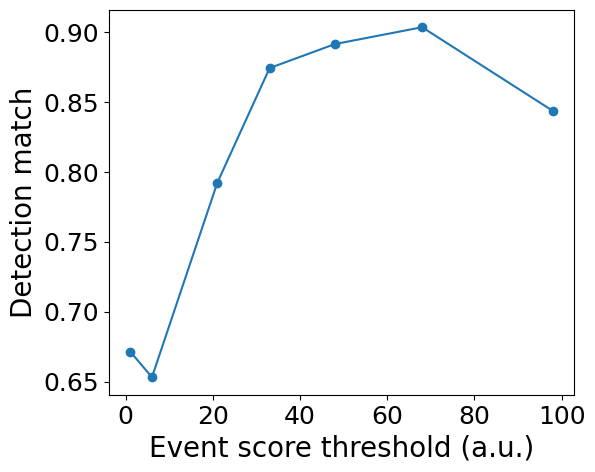

In [91]:
title = 'multich_wp_det_match'
filename = base_dir+'Figures/'+title+'.png'
print(filename)

fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(dilation_threshold, det_match, 'o-')
ax.set(xlabel='Event score threshold (a.u.)', ylabel='Detection match')
#plt.show()
fig.savefig(filename)

## Spatiotemporal filtered Mito & WatProc

### Only mito channel as input

In [92]:
#Inputs
input_data = util.load_h5(data_path, 'Mito')
print('Inputs'+':', input_data.shape)

dilation_sigma = util.load_pkl(data_path, 'max_optimal_sigma')
dilation_threshold = util.load_pkl(data_path, 'max_intensity_threshold')
num_sigmas = dilation_sigma.shape[0]


Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/Mito.h5
Converting to array
Inputs: (37000, 128, 128)

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/max_optimal_sigma

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/max_intensity_threshold


In [ ]:
#Outputs
folder_name = util.get_filename(model_path, 'spatemp_wp')
folder_name = [str(Path(folder).parts[-1]) for folder in folder_name]
folder_name = [folder for folder in folder_name if 'multich' not in folder]
num_models = len(folder_name)

model = util.load_model(model_path, ['model']*num_models, folder_name, as_type=dict)
history = util.load_pkl(model_path, ['history']*num_models, folder_name, as_type=dict)
frames_test = util.load_pkl(model_path, ['frames_test']*num_models, folder_name, as_type=dict)

In [96]:
input_test, output_test, pred_output_test = {}, {}, {}
labels_test = {}

for model_name in folder_name:
  print('\nModel: %s'%model_name)
  metadata = model_name.split('b16_')[-1]
  output_data_name = 'spatemp_WatProc_'+metadata
  labels_name = 'spatemp_proc_labels_'+metadata
  
  #Outputs
  output_data = util.load_h5(data_path, output_data_name)
  print('Outputs:', output_data.shape)
  output_test[model_name] = output_data[frames_test[model_name]]
  del output_data

  labels = util.load_h5(data_path, labels_name)
  print('Labels:', labels.shape)
  labels_test[model_name] = labels[frames_test[model_name]]
  del labels
  
  input_test[model_name] = input_data[frames_test[model_name]]
  pred_output_test[model_name] = evaluation.predict(input_test[model_name], model[model_name])
  
del input_data


Model: spatemp_wp_f8_c9_b16_s2.2_t68_w5_gt109

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/spatemp_WatProc_s2.2_t68_w5_gt109.h5
Converting to array
Outputs: (37000, 128, 128)

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/spatemp_proc_labels_s2.2_t68_w5_gt109.h5
Converting to array
Labels: (37000, 128, 128)
232/232 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step

Model: spatemp_wp_f8_c9_b16_s2.1_t33_w5_gt72

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/spatemp_WatProc_s2.1_t33_w5_gt72.h5
Converting to array
Outputs: (37000, 128, 128)

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/spatemp_proc_labels_s2.1_t33_w5_gt72.h5
Converting to array
Labels: (37000, 128, 128)
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step

Model: spatemp_wp_f8_c9_b16_s2.2_t98_w5_gt127

Loading /mnt/LEB/Scientific_projects/deep_event

#### Threshold optimization

In [97]:
pred_threshold = util.load_pkl(model_path, 'pred_threshold')
f1_score = {}
optimal_pred_threshold = {}
pred_labels_test = {}

for model_name in model:
  print("Processing %s" %model_name)
  f1_score[model_name] = evaluation.get_f1_curve(labels_test[model_name], pred_output_test[model_name], pred_threshold)
  optimal_pred_threshold[model_name] = evaluation.get_optimal_threshold(pred_threshold, f1_score[model_name])
  pred_labels_test[model_name] = evaluation.label(pred_output_test[model_name], threshold=optimal_pred_threshold[model_name])
  print('\n')
  
util.save_pkl(f1_score, model_path, 'spatemp_wp_f1_score')
util.save_pkl(optimal_pred_threshold, model_path, 'spatemp_wp_optimal_pred_threshold')


Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/pred_threshold
Processing spatemp_wp_f8_c9_b16_s2.2_t68_w5_gt109


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:37<00:00,  3.77s/it]




Processing spatemp_wp_f8_c9_b16_s2.1_t33_w5_gt72


100%|██████████| 10/10 [00:40<00:00,  4.07s/it]




Processing spatemp_wp_f8_c9_b16_s2.2_t98_w5_gt127


100%|██████████| 10/10 [00:34<00:00,  3.44s/it]




Processing spatemp_wp_f8_c9_b16_s2.0_t21_w5_gt55


100%|██████████| 10/10 [00:43<00:00,  4.33s/it]




Processing spatemp_wp_f8_c9_b16_s1.9_t6_w5_gt49


100%|██████████| 10/10 [00:43<00:00,  4.30s/it]




Processing spatemp_wp_f8_c9_b16_s1.9_t1_w5_gt38


100%|██████████| 10/10 [00:46<00:00,  4.60s/it]




Processing spatemp_wp_f8_c9_b16_s2.1_t48_w5_gt91


100%|██████████| 10/10 [00:38<00:00,  3.81s/it]





Saving /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/spatemp_wp_f1_score
Done.

Saving /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/spatemp_wp_optimal_pred_threshold
Done.


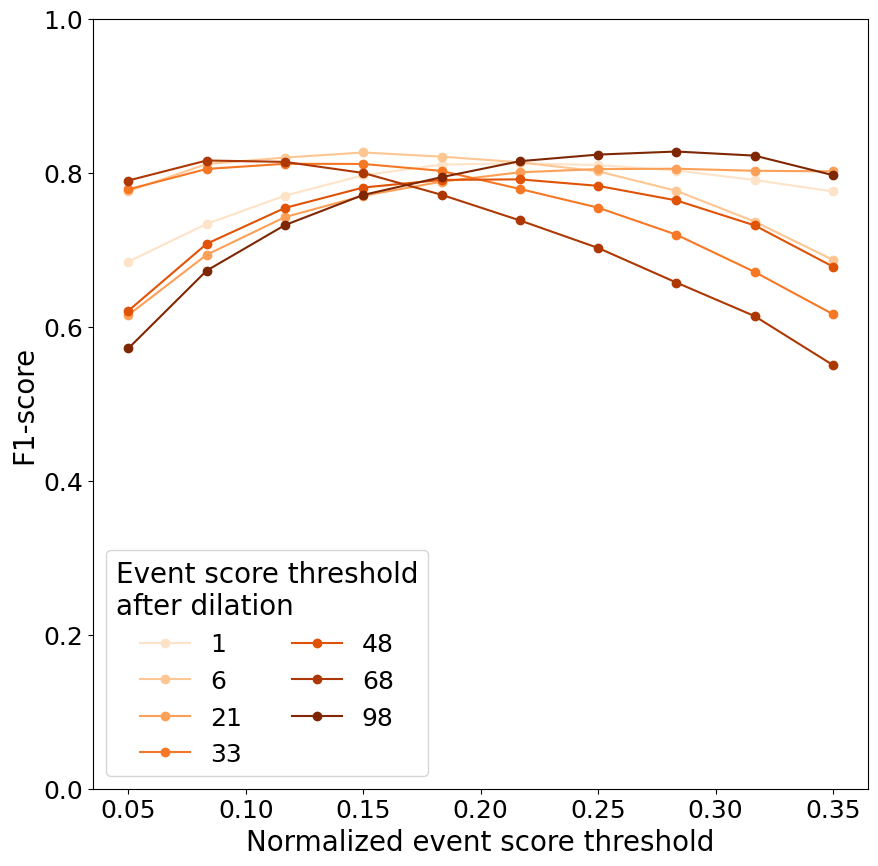

In [98]:
cbar_ticks = np.arange(num_models)

norm_bounds = -1, num_models-1
norm = Normalize(*norm_bounds)
cmap = plt.cm.ScalarMappable(cmap='Oranges', norm=norm)
colors = cmap.get_cmap()(norm(cbar_ticks))

fig, ax = plt.subplots(figsize=(10, 10))
for model_name, thr, c in zip(model, dilation_threshold, colors):
  ax.plot(pred_threshold, f1_score[model_name], 'o-', color=c, label=thr)

ax.set(xlabel='Normalized event score threshold', ylabel='F1-score', ylim=(0, 1))
ax.legend(title='Event score threshold\nafter dilation', title_fontsize=20, ncol=2)
plt.show()

In [ ]:
for model_name in folder_name:
  mask = pred_output_test[model_name]>optimal_pred_threshold[model_name]
  plotting.plot_outputs(input_test[model_name], output_test[model_name], 
                        pred_output_test[model_name]*mask, frames_test[model_name], 
                        nb_examples=5, title=model_name, cmap=['gray', 'inferno'])
  plt.show()
  print('\n')

#### Labels binary overlap

In [99]:
fissionStats = {}
for model_name in labels_test:
  print('\nModel name:', model_name)
  fissionStats[model_name] = evaluation.fissionStatsStack(labels_test[model_name], pred_labels_test[model_name])


Model name: spatemp_wp_f8_c9_b16_s2.2_t68_w5_gt109

Model name: spatemp_wp_f8_c9_b16_s2.1_t33_w5_gt72

Model name: spatemp_wp_f8_c9_b16_s2.2_t98_w5_gt127

Model name: spatemp_wp_f8_c9_b16_s2.0_t21_w5_gt55

Model name: spatemp_wp_f8_c9_b16_s1.9_t6_w5_gt49

Model name: spatemp_wp_f8_c9_b16_s1.9_t1_w5_gt38

Model name: spatemp_wp_f8_c9_b16_s2.1_t48_w5_gt91


In [100]:
fissionStats = pd.DataFrame(fissionStats, index=['TP', 'FP', 'FN', 'TP_px', 'FP_px', 'FN_px']).T
fissionStats['precision'] = fissionStats['TP']/(fissionStats['TP']+fissionStats['FP'])
fissionStats['TPR'] = fissionStats['TP']/(fissionStats['TP']+fissionStats['FN'])
fissionStats['FDR'] = fissionStats['FP']/(fissionStats['TP']+fissionStats['FP'])

fissionStats['precision_px'] = fissionStats['TP_px']/(fissionStats['TP_px']+fissionStats['FP_px'])
fissionStats['TPR_px'] = fissionStats['TP_px']/(fissionStats['TP_px']+fissionStats['FN_px'])
fissionStats['FDR_px'] = fissionStats['FP_px']/(fissionStats['TP_px']+fissionStats['FP_px'])

fissionStats = fissionStats.T

/mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Figures/spatemp_wp_fissionStats.png


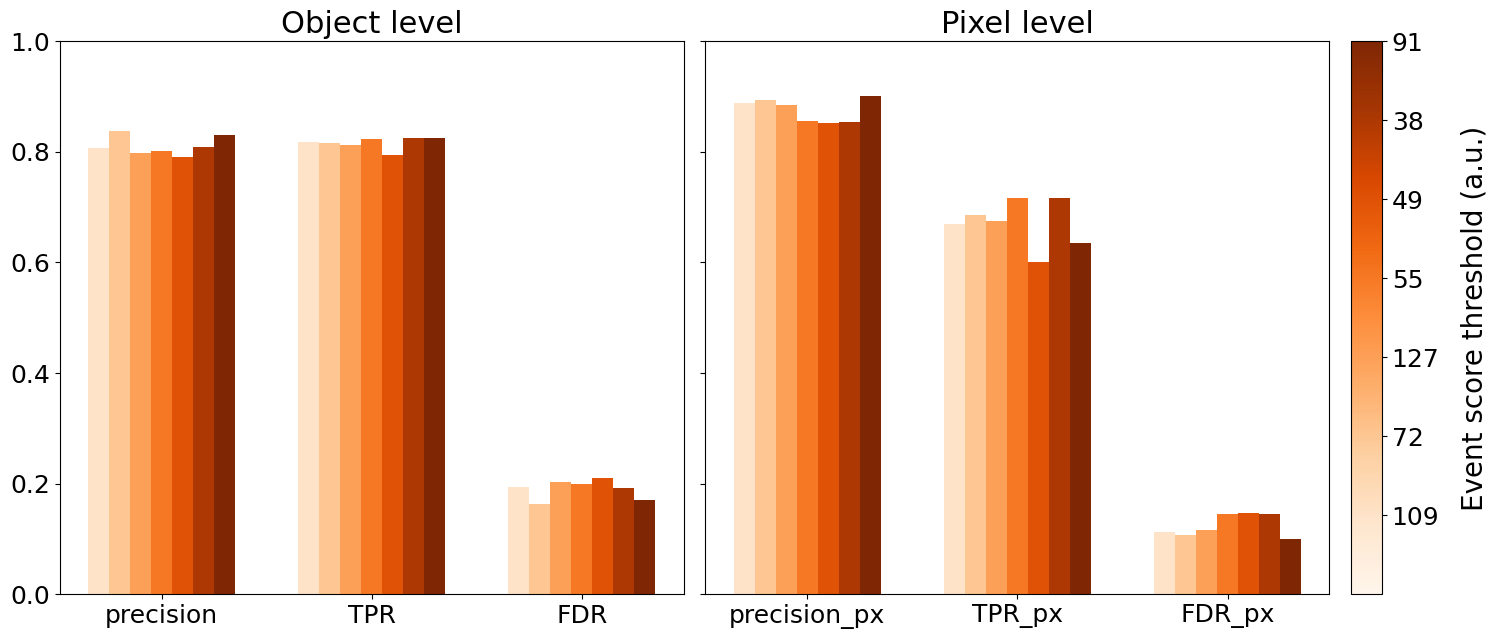

In [101]:
gaussian_threshold = np.array([int(model_name.split('_gt')[-1]) for model_name in model])
title = 'spatemp_wp_fissionStats'
filename = base_dir+'Figures/'+title+'.png'
print(filename)

fig = plt.figure(figsize=(7*2, 7))
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 0.05])

axes = []
axes += [fig.add_subplot(gs[0])]
axes += [fig.add_subplot(gs[1])]
cax = fig.add_subplot(gs[2])

plotting.plot_metrics_comparison(fissionStats.loc[['precision', 'TPR', 'FDR']], xscale=2, color=colors, ax=axes[0], ylim=[0, 1], legend=False)  
plotting.plot_metrics_comparison(fissionStats.loc[['precision_px', 'TPR_px', 'FDR_px']], xscale=2, color=colors, ax=axes[1], ylim=[0, 1], legend=False)
axes[1].set_yticklabels([])

for ax, title in zip(axes, ['Object level', 'Pixel level']):
  ax.set_title(title, size=22)
  ax.tick_params(axis='x')
  ax.tick_params(axis='y')

cbar = fig.colorbar(cmap, cax=cax, ticks=cbar_ticks)
cbar.set_ticklabels(gaussian_threshold)
cbar.set_label('Event score threshold (a.u.)', labelpad=15)


plt.tight_layout(pad=0)
fig.subplots_adjust(wspace=0.05, top=0.84, right=0.98)

#plt.show()
fig.savefig(filename)

#### Detection match

In [102]:
det_match = [evaluation.detection_match(output_test[model_name], pred_output_test[model_name]) for model_name in folder_name]

/mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Figures/spatemp_wp_det_match.png


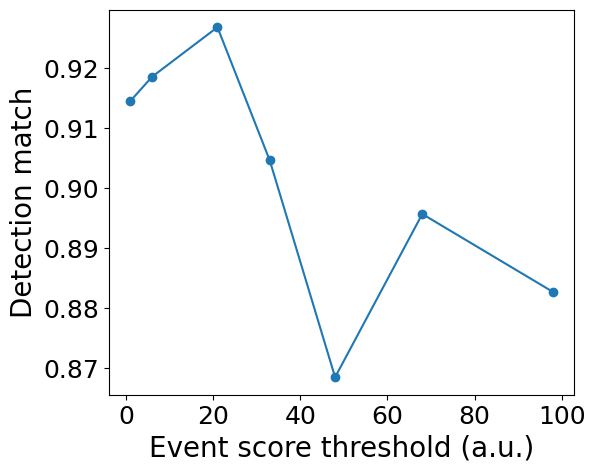

In [103]:
title = 'spatemp_wp_det_match'
filename = base_dir+'Figures/'+title+'.png'
print(filename)

fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(dilation_threshold, det_match, 'o-')
ax.set(xlabel='Event score threshold (a.u.)', ylabel='Detection match')
#plt.show()
fig.savefig(filename)

### Mito + Drp1 channels as inputs

In [104]:
#Inputs
input_data = util.load_h5(data_path, 'Mito')
input_data = np.stack((input_data, util.load_h5(data_path, 'Drp1')), axis=-1)
print('Inputs'+':', input_data.shape)

dilation_sigma = util.load_pkl(data_path, 'max_optimal_sigma')
dilation_threshold = util.load_pkl(data_path, 'max_intensity_threshold')
num_sigmas = dilation_sigma.shape[0]


Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/Mito.h5
Converting to array

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/Drp1.h5
Converting to array
Inputs: (37000, 128, 128, 2)

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/max_optimal_sigma

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/max_intensity_threshold


In [105]:
#Outputs
folder_name = util.get_filename(model_path, 'multich_spatemp_wp_f8')
folder_name = [str(Path(folder).parts[-1]) for folder in folder_name]
num_models = len(folder_name)

model = util.load_model(model_path, ['model']*num_models, folder_name, as_type=dict)
history = util.load_pkl(model_path, ['history']*num_models, folder_name, as_type=dict)
frames_test = util.load_pkl(model_path, ['frames_test']*num_models, folder_name, as_type=dict)


Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_spatemp_wp_f8_c9_b16_s2.1_t33_w5_gt72/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_spatemp_wp_f8_c9_b16_s1.9_t6_w5_gt49/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_spatemp_wp_f8_c9_b16_s2.0_t21_w5_gt55/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_spatemp_wp_f8_c9_b16_s2.1_t48_w5_gt91/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_spatemp_wp_f8_c9_b16_s1.9_t1_w5_gt38/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_spatemp_wp_f8_c9_b16_s2.2_t98_w5_gt127/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_spatemp_wp_f8_c9_b16_s2.2_t68_w5_gt109/model.h5


Done.

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_spatemp_wp_f8_c9_b16_s2.1_t33_w5_gt72/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_spatemp_wp_f8_c9_b16_s1.9_t6_w5_gt49/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_spatemp_wp_f8_c9_b16_s2.0_t21_w5_gt55/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_spatemp_wp_f8_c9_b16_s2.1_t48_w5_gt91/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_spatemp_wp_f8_c9_b16_s1.9_t1_w5_gt38/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_spatemp_wp_f8_c9_b16_s2.2_t98_w5_gt127/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo

In [106]:
input_test, output_test, pred_output_test = {}, {}, {}
labels_test = {}

for model_name in folder_name:
  print('\nModel: %s'%model_name)
  metadata = model_name.split('b16_')[-1]
  output_data_name = 'spatemp_WatProc_'+metadata
  labels_name = 'spatemp_proc_labels_'+metadata
  
  #Outputs
  output_data = util.load_h5(data_path, output_data_name)
  print('Outputs:', output_data.shape)
  output_test[model_name] = output_data[frames_test[model_name]]
  del output_data

  labels = util.load_h5(data_path, labels_name)
  print('Labels:', labels.shape)
  labels_test[model_name] = labels[frames_test[model_name]]
  del labels
  
  input_test[model_name] = input_data[frames_test[model_name]]
  pred_output_test[model_name] = evaluation.predict(input_test[model_name], model[model_name])
  
del input_data


Model: multich_spatemp_wp_f8_c9_b16_s2.1_t33_w5_gt72

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/spatemp_WatProc_s2.1_t33_w5_gt72.h5
Converting to array
Outputs: (37000, 128, 128)

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/spatemp_proc_labels_s2.1_t33_w5_gt72.h5
Converting to array
Labels: (37000, 128, 128)
232/232 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step

Model: multich_spatemp_wp_f8_c9_b16_s1.9_t6_w5_gt49

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/spatemp_WatProc_s1.9_t6_w5_gt49.h5
Converting to array
Outputs: (37000, 128, 128)

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/spatemp_proc_labels_s1.9_t6_w5_gt49.h5
Converting to array
Labels: (37000, 128, 128)
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Model: multich_spatemp_wp_f8_c9_b16_s2.0_t21_w5_gt55

Loading /mnt/LEB/Scientific_pr

#### Threshold optimization

In [107]:
pred_threshold = util.load_pkl(model_path, 'pred_threshold')
f1_score = {}
optimal_pred_threshold = {}
pred_labels_test = {}

for model_name in model:
  print("Processing %s" %model_name)
  f1_score[model_name] = evaluation.get_f1_curve(labels_test[model_name], pred_output_test[model_name], pred_threshold)
  optimal_pred_threshold[model_name] = evaluation.get_optimal_threshold(pred_threshold, f1_score[model_name])
  pred_labels_test[model_name] = evaluation.label(pred_output_test[model_name], threshold=optimal_pred_threshold[model_name])
  print('\n')
  
util.save_pkl(f1_score, model_path, 'multich_spatemp_f1_score')
util.save_pkl(optimal_pred_threshold, model_path, 'multich_spatemp_optimal_pred_threshold')


Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/pred_threshold
Processing multich_spatemp_wp_f8_c9_b16_s2.1_t33_w5_gt72


100%|██████████| 10/10 [00:41<00:00,  4.10s/it]




Processing multich_spatemp_wp_f8_c9_b16_s1.9_t6_w5_gt49


100%|██████████| 10/10 [00:44<00:00,  4.45s/it]




Processing multich_spatemp_wp_f8_c9_b16_s2.0_t21_w5_gt55


100%|██████████| 10/10 [00:44<00:00,  4.47s/it]




Processing multich_spatemp_wp_f8_c9_b16_s2.1_t48_w5_gt91


100%|██████████| 10/10 [00:40<00:00,  4.08s/it]




Processing multich_spatemp_wp_f8_c9_b16_s1.9_t1_w5_gt38


100%|██████████| 10/10 [00:47<00:00,  4.78s/it]




Processing multich_spatemp_wp_f8_c9_b16_s2.2_t98_w5_gt127


100%|██████████| 10/10 [00:35<00:00,  3.52s/it]




Processing multich_spatemp_wp_f8_c9_b16_s2.2_t68_w5_gt109


100%|██████████| 10/10 [00:38<00:00,  3.85s/it]





Saving /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_spatemp_f1_score
Done.

Saving /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_spatemp_optimal_pred_threshold
Done.


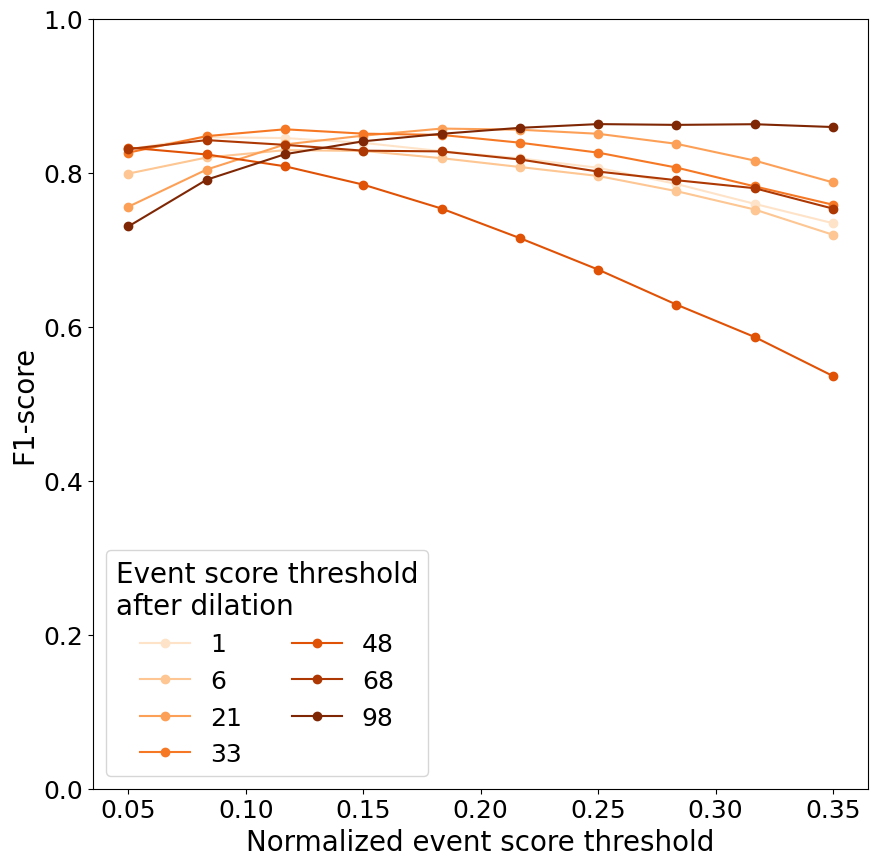

In [108]:
cbar_ticks = np.arange(num_models)

norm_bounds = -1, num_models-1
norm = Normalize(*norm_bounds)
cmap = plt.cm.ScalarMappable(cmap='Oranges', norm=norm)
colors = cmap.get_cmap()(norm(cbar_ticks))

fig, ax = plt.subplots(figsize=(10, 10))
for model_name, thr, c in zip(model, dilation_threshold, colors):
  ax.plot(pred_threshold, f1_score[model_name], 'o-', color=c, label=thr)

ax.set(xlabel='Normalized event score threshold', ylabel='F1-score', ylim=(0, 1))
ax.legend(title='Event score threshold\nafter dilation', title_fontsize=20, ncol=2)
plt.show()

In [ ]:
for model_name in folder_name:
  mask = pred_output_test[model_name]>optimal_pred_threshold[model_name]
  plotting.plot_outputs(input_test[model_name][:, :, :, 0], output_test[model_name], 
                        pred_output_test[model_name]*mask, frames_test[model_name], 
                        nb_examples=5, title=model_name, cmap=['gray', 'inferno'])
  plt.show()
  print('\n')

#### Labels binary overlap

In [109]:
fissionStats = {}
for model_name in labels_test:
  print('\nModel name:', model_name)
  fissionStats[model_name] = evaluation.fissionStatsStack(labels_test[model_name], pred_labels_test[model_name])


Model name: multich_spatemp_wp_f8_c9_b16_s2.1_t33_w5_gt72

Model name: multich_spatemp_wp_f8_c9_b16_s1.9_t6_w5_gt49

Model name: multich_spatemp_wp_f8_c9_b16_s2.0_t21_w5_gt55

Model name: multich_spatemp_wp_f8_c9_b16_s2.1_t48_w5_gt91

Model name: multich_spatemp_wp_f8_c9_b16_s1.9_t1_w5_gt38

Model name: multich_spatemp_wp_f8_c9_b16_s2.2_t98_w5_gt127

Model name: multich_spatemp_wp_f8_c9_b16_s2.2_t68_w5_gt109


In [110]:
fissionStats = pd.DataFrame(fissionStats, index=['TP', 'FP', 'FN', 'TP_px', 'FP_px', 'FN_px']).T
fissionStats['precision'] = fissionStats['TP']/(fissionStats['TP']+fissionStats['FP'])
fissionStats['TPR'] = fissionStats['TP']/(fissionStats['TP']+fissionStats['FN'])
fissionStats['FDR'] = fissionStats['FP']/(fissionStats['TP']+fissionStats['FP'])

fissionStats['precision_px'] = fissionStats['TP_px']/(fissionStats['TP_px']+fissionStats['FP_px'])
fissionStats['TPR_px'] = fissionStats['TP_px']/(fissionStats['TP_px']+fissionStats['FN_px'])
fissionStats['FDR_px'] = fissionStats['FP_px']/(fissionStats['TP_px']+fissionStats['FP_px'])

fissionStats = fissionStats.T

/mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Figures/multich_spatemp_fissionStats.png


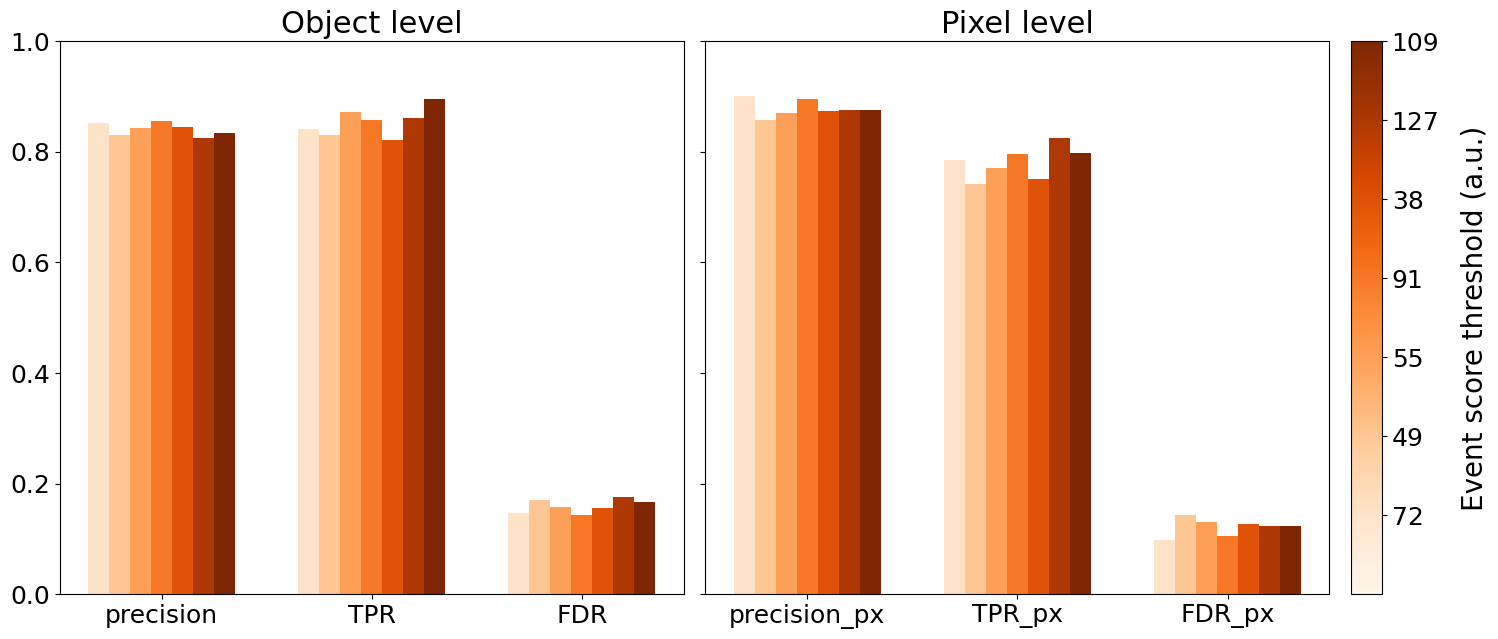

In [111]:
gaussian_threshold = np.array([int(model_name.split('_gt')[-1]) for model_name in model])
title = 'multich_spatemp_fissionStats'
filename = base_dir+'Figures/'+title+'.png'
print(filename)

fig = plt.figure(figsize=(7*2, 7))
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 0.05])

axes = []
axes += [fig.add_subplot(gs[0])]
axes += [fig.add_subplot(gs[1])]
cax = fig.add_subplot(gs[2])

plotting.plot_metrics_comparison(fissionStats.loc[['precision', 'TPR', 'FDR']], xscale=2, color=colors, ax=axes[0], ylim=[0, 1], legend=False)  
plotting.plot_metrics_comparison(fissionStats.loc[['precision_px', 'TPR_px', 'FDR_px']], xscale=2, color=colors, ax=axes[1], ylim=[0, 1], legend=False)
axes[1].set_yticklabels([])

for ax, title in zip(axes, ['Object level', 'Pixel level']):
  ax.set_title(title, size=22)
  ax.tick_params(axis='x')
  ax.tick_params(axis='y')

cbar = fig.colorbar(cmap, cax=cax, ticks=cbar_ticks)
cbar.set_ticklabels(gaussian_threshold)
cbar.set_label('Event score threshold (a.u.)', labelpad=15)


plt.tight_layout(pad=0)
fig.subplots_adjust(wspace=0.05, top=0.84, right=0.98)

#plt.show()
fig.savefig(filename)

#### Detection match

In [112]:
det_match = [evaluation.detection_match(output_test[model_name], pred_output_test[model_name]) for model_name in folder_name]

/mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Figures/multich_spatemp_wp_det_match.png


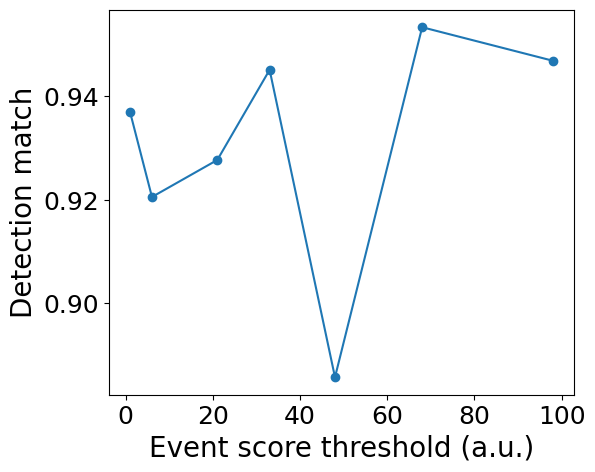

In [113]:
title = 'multich_spatemp_wp_det_match'
filename = base_dir+'Figures/'+title+'.png'
print(filename)

fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(dilation_threshold, det_match, 'o-')
ax.set(xlabel='Event score threshold (a.u.)', ylabel='Detection match')
#plt.show()
fig.savefig(filename)